# Preparation

### Setup working Directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%mkdir project

In [ ]:
%cd drive/MyDrive/ECE_281B

/content/drive/MyDrive/ECE_281B


In [ ]:
%cp -av Image-Extension/* /content/project

'Image-Extension/checkpoints' -> '/content/project/checkpoints'
'Image-Extension/checkpoints/.gitignore' -> '/content/project/checkpoints/.gitignore'
'Image-Extension/dataset' -> '/content/project/dataset'
'Image-Extension/dataset/.gitignore' -> '/content/project/dataset/.gitignore'
'Image-Extension/dataset/.DS_Store' -> '/content/project/dataset/.DS_Store'
'Image-Extension/dataset/img' -> '/content/project/dataset/img'
'Image-Extension/dataset/img/.gitignore' -> '/content/project/dataset/img/.gitignore'
'Image-Extension/dataset/img/.DS_Store' -> '/content/project/dataset/img/.DS_Store'
'Image-Extension/dataset/mask' -> '/content/project/dataset/mask'
'Image-Extension/dataset/mask/.gitignore' -> '/content/project/dataset/mask/.gitignore'
'Image-Extension/logs' -> '/content/project/logs'
'Image-Extension/logs/.gitignore' -> '/content/project/logs/.gitignore'
'Image-Extension/logs/PConvUNet_Rectangle.png' -> '/content/project/logs/PConvUNet_Rectangle.png'
'Image-Extension/models' -> '/co

### Load Checkpoints from Drive

In [ ]:
%cp -av checkpoints/*500.pth /content/project/checkpoints/PConvUNet_Rectangle_500.pth
%cp -av checkpoints/*650.pth /content/project/checkpoints/PConvUNet_Rectangle_650.pth
%cp -av checkpoints/*700.pth /content/project/checkpoints/PConvUNet_Rectangle_700.pth

'checkpoints/PConvUNet_Rectangle_500.pth' -> '/content/project/checkpoints/PConvUNet_Rectangle_500.pth'
'checkpoints/PConvUNet_Rectangle_650.pth' -> '/content/project/checkpoints/PConvUNet_Rectangle_650.pth'
'checkpoints/PConvUNet_Rectangle_700.pth' -> '/content/project/checkpoints/PConvUNet_Rectangle_700.pth'


In [ ]:
%cd /content/

/content


### Required Libraries

In [ ]:
!pip install torchmetrics
!pip install kaggle
!pip install torchmetrics[image]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 30.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 KB 4.7 MB/s eta 0:00:00


### Dataset

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d nickj26/places2-mit-dataset/train_256_places365standard/data_256

100% 27.8G/27.8G [23:23<00:00, 24.2MB/s]
100% 27.8G/27.8G [23:23<00:00, 21.3MB/s]


In [ ]:
! unzip places2-mit-dataset.zip -d project/dataset

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: project/dataset/val_256/val_256/Places365_val_00031501.jpg  
  inflating: project/dataset/val_256/val_256/Places365_val_00031502.jpg  
  inflating: project/dataset/val_256/val_256/Places365_val_00031503.jpg  
  inflating: project/dataset/val_256/val_256/Places365_val_00031504.jpg  
  inflating: project/dataset/val_256/val_256/Places365_val_00031505.jpg  
  inflating: project/dataset/val_256/val_256/Places365_val_00031506.jpg  
  inflating: project/dataset/val_256/val_256/Places365_val_00031507.jpg  
  inflating: project/dataset/val_256/val_256/Places365_val_00031508.jpg  
  inflating: project/dataset/val_256/val_256/Places365_val_00031509.jpg  
  inflating: project/dataset/val_256/val_256/Places365_val_00031510.jpg  
  inflating: project/dataset/val_256/val_256/Places365_val_00031511.jpg  
  inflating: project/dataset/val_256/val_256/Places365_val_00031512.jpg  
  inflating: project/dataset/val_256/val_256/Places365_val_00031513.jpg  
  inflating

### Test Set

In [ ]:
%mkdir project/dataset/test

In [ ]:
%cp -av drive/MyDrive/ECE_281B/dataset/test/* project/dataset/test

'drive/MyDrive/ECE_281B/dataset/test/00000006.jpg' -> 'project/dataset/test/00000006.jpg'
'drive/MyDrive/ECE_281B/dataset/test/00000008.jpg' -> 'project/dataset/test/00000008.jpg'
'drive/MyDrive/ECE_281B/dataset/test/00000012.jpg' -> 'project/dataset/test/00000012.jpg'
'drive/MyDrive/ECE_281B/dataset/test/00000050.jpg' -> 'project/dataset/test/00000050.jpg'
'drive/MyDrive/ECE_281B/dataset/test/00000157.jpg' -> 'project/dataset/test/00000157.jpg'
'drive/MyDrive/ECE_281B/dataset/test/originalImg.jpg' -> 'project/dataset/test/originalImg.jpg'


## import required libararies

In [ ]:
from project.utils.data_loader import make_datapath_list, ImageDataset, ImageTransform
from project.models.UNet_with_PConv import PConvUNet
from project.models.loss import Losses
from project.models.metrics import Evaluator
from torchvision import models
from collections import OrderedDict
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import argparse
import time
import torch
import os
import glob

## Helper Functions

In [ ]:
def fix_model_state_dict(state_dict):
    """
    remove 'module.' of data parallel
    """
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k
        if name.startswith('module.'):
            name = name[7:]
        new_state_dict[name] = v
    return new_state_dict


def plot_log(data, save_model_name='model'):
    plt.cla()
    plt.plot(data, label='total_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss')
    plt.savefig('./logs/'+save_model_name+'.png')


def check_dir():
    if not os.path.exists('./logs'):
        os.mkdir('./logs')
    if not os.path.exists('./checkpoints'):
        os.mkdir('./checkpoints')
    if not os.path.exists('./result'):
        os.mkdir('./result')


## Train Loop

In [ ]:
def train_model(pconv_unet, dataloader, val_dataset, num_epochs, parser, save_model_name='model'):

    check_dir()

    device = "cuda" if torch.cuda.is_available() else "cpu"

    pconv_unet.to(device)

    print("device:{}".format(device))
    '''
    if parser.finetune:
        lr = parser.lr_fine
        pconv_unet.fine_tune = True
    else:
        lr = parser.lr
    '''
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, pconv_unet.parameters()), lr=lr)
    criterion = Losses().to(device)
   
    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    lambda_dict = {'valid': 1.0, 'hole': 6.0, 'perceptual': 0.05, 'style': 120, 'tv': 0.1, 'bfm': 0.01}

    iteration = 1
    losses = []

    for epoch in range(num_epochs):

        pconv_unet.train()
        t_epoch_start = time.time()

        epoch_loss = 0.0

        print('-----------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('(train)')

        for images, mask, gt in tqdm(dataloader):

            # if size of minibatch is 1, an error would be occurred.
            if images.size()[0] == 1:
                continue

            images = images.to(device)
            mask = mask.to(device)
            gt = gt.to(device)

            mini_batch_size = images.size()[0]

            output, _, fb = pconv_unet(images, mask, gt)
            loss_dict = criterion(images, mask, output, gt, fb)

            loss = torch.tensor(0.0).to(device)
            for key, _lambda in lambda_dict.items():
                loss += _lambda * loss_dict[key]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print('-----------')
        print('epoch {}'.format(epoch+1))
        print('total_loss:{:.4f}'.format(epoch_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))

        losses.append(epoch_loss/batch_size)
        t_epoch_start = time.time()
        plot_log(losses, save_model_name)

        if (epoch+1) % 10 == 0:
            torch.save(pconv_unet.state_dict(), 'project/checkpoints/'+save_model_name+'_'+str(epoch+1)+'.pth')
            pconv_unet.eval()
            evaluator = Evaluator(pconv_unet, device)
            metrics = evaluator.evaluate(val_dataset, device, 'project/{:s}/test_{:d}.jpg'.format('result', epoch))
            print('metrics: PSNR = {:.2f}, SSIM = {:.2f}'.format(metrics['PSNR'], metrics['SSIM']))
    return pconv_unet

## Traininng Params

In [ ]:
epoch = 100
batch_size = 10
image_size = 256
lr = 1e-3

# Train Model

### Epoch 0-100

project/dataset/train_256_places365standard/data_256/a/aquarium/*.jpg
project/dataset//a/aquarium/*.jpg
device:cuda
-----------
Epoch 1/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 1
total_loss:503.8850
timer: 310.5654 sec.
metrics: PSNR = 7.65, SSIM = 0.64
-----------
Epoch 2/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 2
total_loss:311.8790
timer: 310.9510 sec.
-----------
Epoch 3/100
(train)


100%|██████████| 1600/1600 [05:11<00:00,  5.14it/s]


-----------
epoch 3
total_loss:264.4780
timer: 311.3686 sec.
-----------
Epoch 4/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 4
total_loss:240.0857
timer: 310.6273 sec.
-----------
Epoch 5/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f31c8abe4c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1424, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


-----------
epoch 5
total_loss:222.7729
timer: 310.5418 sec.
-----------
Epoch 6/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.14it/s]


-----------
epoch 6
total_loss:208.6929
timer: 311.0065 sec.
-----------
Epoch 7/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 7
total_loss:196.0902
timer: 310.9568 sec.
-----------
Epoch 8/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 8
total_loss:185.7008
timer: 310.6960 sec.
-----------
Epoch 9/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 9
total_loss:177.4211
timer: 310.5349 sec.
-----------
Epoch 10/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 10
total_loss:170.4688
timer: 310.6050 sec.
-----------
Epoch 11/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 11
total_loss:164.0241
timer: 310.8756 sec.
metrics: PSNR = 9.36, SSIM = 1.23
-----------
Epoch 12/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 12
total_loss:157.4105
timer: 310.6114 sec.
-----------
Epoch 13/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 13
total_loss:150.4004
timer: 310.4266 sec.
-----------
Epoch 14/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 14
total_loss:143.7619
timer: 310.8411 sec.
-----------
Epoch 15/100
(train)


100%|██████████| 1600/1600 [05:11<00:00,  5.14it/s]


-----------
epoch 15
total_loss:137.5254
timer: 311.0818 sec.
-----------
Epoch 16/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 16
total_loss:131.5993
timer: 310.4143 sec.
-----------
Epoch 17/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 17
total_loss:125.7511
timer: 310.7485 sec.
-----------
Epoch 18/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 18
total_loss:120.2710
timer: 310.6658 sec.
-----------
Epoch 19/100
(train)


100%|██████████| 1600/1600 [05:11<00:00,  5.13it/s]


-----------
epoch 19
total_loss:115.8074
timer: 311.6959 sec.
-----------
Epoch 20/100
(train)


100%|██████████| 1600/1600 [05:11<00:00,  5.14it/s]


-----------
epoch 20
total_loss:111.7832
timer: 311.2186 sec.
-----------
Epoch 21/100
(train)


100%|██████████| 1600/1600 [05:11<00:00,  5.14it/s]


-----------
epoch 21
total_loss:108.6771
timer: 311.1328 sec.
metrics: PSNR = 9.89, SSIM = 1.42
-----------
Epoch 22/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 22
total_loss:105.6046
timer: 310.9135 sec.
-----------
Epoch 23/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 23
total_loss:103.5935
timer: 310.6669 sec.
-----------
Epoch 24/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 24
total_loss:101.4593
timer: 310.8002 sec.
-----------
Epoch 25/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 25
total_loss:99.4921
timer: 310.7260 sec.
-----------
Epoch 26/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 26
total_loss:97.9479
timer: 310.5011 sec.
-----------
Epoch 27/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 27
total_loss:96.2826
timer: 310.8128 sec.
-----------
Epoch 28/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 28
total_loss:94.3987
timer: 310.7778 sec.
-----------
Epoch 29/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 29
total_loss:92.5448
timer: 310.8151 sec.
-----------
Epoch 30/100
(train)


100%|██████████| 1600/1600 [05:11<00:00,  5.14it/s]


-----------
epoch 30
total_loss:91.3748
timer: 311.0734 sec.
-----------
Epoch 31/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 31
total_loss:89.6334
timer: 310.7999 sec.
metrics: PSNR = 10.06, SSIM = 1.66
-----------
Epoch 32/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 32
total_loss:88.3582
timer: 310.7708 sec.
-----------
Epoch 33/100
(train)


100%|██████████| 1600/1600 [05:11<00:00,  5.14it/s]


-----------
epoch 33
total_loss:87.1196
timer: 311.2432 sec.
-----------
Epoch 34/100
(train)


100%|██████████| 1600/1600 [05:11<00:00,  5.14it/s]


-----------
epoch 34
total_loss:86.4109
timer: 311.1219 sec.
-----------
Epoch 35/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 35
total_loss:85.1287
timer: 310.9724 sec.
-----------
Epoch 36/100
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 36
total_loss:84.2862
timer: 310.9340 sec.
-----------
Epoch 37/100
(train)


100%|██████████| 1600/1600 [05:11<00:00,  5.14it/s]


-----------
epoch 37
total_loss:83.5890
timer: 311.2291 sec.
-----------
Epoch 38/100
(train)


100%|██████████| 1600/1600 [05:11<00:00,  5.14it/s]


-----------
epoch 38
total_loss:82.8222
timer: 311.3758 sec.
-----------
Epoch 39/100
(train)


100%|██████████| 1600/1600 [05:11<00:00,  5.14it/s]


-----------
epoch 39
total_loss:81.9572
timer: 311.1050 sec.
-----------
Epoch 40/100
(train)


100%|██████████| 1600/1600 [05:11<00:00,  5.14it/s]


-----------
epoch 40
total_loss:81.2234
timer: 311.4644 sec.
-----------
Epoch 41/100
(train)


100%|██████████| 1600/1600 [05:12<00:00,  5.12it/s]


-----------
epoch 41
total_loss:80.7884
timer: 312.7874 sec.
metrics: PSNR = 10.23, SSIM = 1.73
-----------
Epoch 42/100
(train)


100%|██████████| 1600/1600 [05:11<00:00,  5.14it/s]


-----------
epoch 42
total_loss:80.0039
timer: 311.4362 sec.
-----------
Epoch 43/100
(train)


100%|██████████| 1600/1600 [05:11<00:00,  5.13it/s]


-----------
epoch 43
total_loss:79.7867
timer: 311.6346 sec.
-----------
Epoch 44/100
(train)


 70%|███████   | 1123/1600 [03:39<01:33,  5.11it/s]


KeyboardInterrupt: ignored

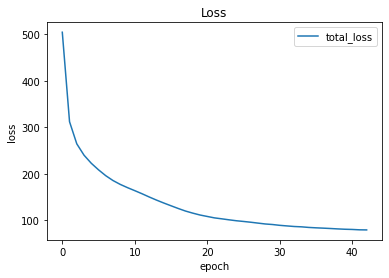

In [ ]:
pconv_unet = PConvUNet()

#pconv_weights = torch.load('./checkpoints/PConvUNet_PConvUNet_3.pth')
#pconv_unet.load_state_dict(fix_model_state_dict(pconv_weights))

train_img_list, val_img_list = make_datapath_list(iorm='img', path='train_256_places365standard/data_256', phase='train', dataset_num=20000)
mask_list = make_datapath_list(iorm='mask', path='')

mean = (0.5,)
std = (0.5,)
size = (image_size, 2 * image_size)
batch_size = batch_size
num_epochs = epoch

train_dataset = ImageDataset(img_list=train_img_list,
                                img_transform=ImageTransform(size=size, mean=mean, std=std),
                                mask_width=0.5)
val_dataset = ImageDataset(img_list=val_img_list,
                            img_transform=ImageTransform(size=size, mean=mean, std=std),
                            mask_width=0.5)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

pconv_unet_update = train_model(pconv_unet, dataloader=train_dataloader,
                                val_dataset=val_dataset, num_epochs=num_epochs,
                                parser=None, save_model_name='PConvUNet_Rectangle')


In [ ]:
%cp -av project/checkpoints/* drive/MyDrive/ECE_281B/checkpoints

In [ ]:
%cp -av project/result/* drive/MyDrive/ECE_281B/result

## Fine Tuning

In [ ]:
def train_model(pconv_unet, dataloader, val_dataset, num_epochs, parser, save_model_name='model'):

    check_dir()

    device = "cuda" if torch.cuda.is_available() else "cpu"

    pconv_unet.to(device)

    print("device:{}".format(device))
    '''
    if parser.finetune:
        lr = parser.lr_fine
        pconv_unet.fine_tune = True
    else:
        lr = parser.lr
    '''
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, pconv_unet.parameters()), lr=lr)
    criterion = Losses().to(device)
   
    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    lambda_dict = {'valid': 1.0, 'hole': 6.0, 'perceptual': 20, 'style': 120, 'tv': 0.1, 'bfm': 0.001}

    iteration = 1
    losses = []

    for epoch in range(170, num_epochs+170):

        pconv_unet.train()
        t_epoch_start = time.time()

        epoch_loss = 0.0

        print('-----------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs+170))
        print('(train)')

        for images, mask, gt in tqdm(dataloader):

            # if size of minibatch is 1, an error would be occurred.
            if images.size()[0] == 1:
                continue

            images = images.to(device)
            mask = mask.to(device)
            gt = gt.to(device)

            mini_batch_size = images.size()[0]

            output, _, fb = pconv_unet(images, mask, gt)
            loss_dict = criterion(images, mask, output, gt, fb)

            loss = torch.tensor(0.0).to(device)
            for key, _lambda in lambda_dict.items():
                loss += _lambda * loss_dict[key]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print('-----------')
        print('epoch {}'.format(epoch+1))
        print('total_loss:{:.4f}'.format(epoch_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))

        losses.append(epoch_loss/batch_size)
        t_epoch_start = time.time()
        plot_log(losses, save_model_name)

        if (epoch+1) % 10 == 0:
            torch.save(pconv_unet.state_dict(), 'project/checkpoints/'+save_model_name+'_'+str(epoch+1)+'.pth')
            pconv_unet.eval()
            evaluator = Evaluator(pconv_unet, device)
            metrics = evaluator.evaluate(val_dataset, device, 'project/{:s}/test_{:d}.jpg'.format('result', epoch+1))
            print('metrics: PSNR = {:.2f}, SSIM = {:.2f}'.format(metrics['PSNR'], metrics['SSIM']))
    return pconv_unet

In [ ]:
epoch = 30
batch_size = 6
image_size = 256
lr = 1e-4

### Epoch 170-200

project/dataset/train_256_places365standard/data_256/a/aquarium/*.jpg
device:cuda


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


-----------
Epoch 171/200
(train)


100%|██████████| 2667/2667 [06:18<00:00,  7.05it/s]


-----------
epoch 171
total_loss:185.4316
timer: 378.0521 sec.
-----------
Epoch 172/200
(train)


100%|██████████| 2667/2667 [06:11<00:00,  7.19it/s]


-----------
epoch 172
total_loss:183.0589
timer: 371.1809 sec.
-----------
Epoch 173/200
(train)


100%|██████████| 2667/2667 [06:11<00:00,  7.18it/s]


-----------
epoch 173
total_loss:181.2036
timer: 371.5401 sec.
-----------
Epoch 174/200
(train)


100%|██████████| 2667/2667 [06:11<00:00,  7.18it/s]


-----------
epoch 174
total_loss:179.6822
timer: 371.7006 sec.
-----------
Epoch 175/200
(train)


100%|██████████| 2667/2667 [06:11<00:00,  7.19it/s]


-----------
epoch 175
total_loss:178.6044
timer: 371.1100 sec.
-----------
Epoch 176/200
(train)


100%|██████████| 2667/2667 [06:10<00:00,  7.20it/s]


-----------
epoch 176
total_loss:177.3629
timer: 370.6144 sec.
-----------
Epoch 177/200
(train)


100%|██████████| 2667/2667 [06:11<00:00,  7.18it/s]


-----------
epoch 177
total_loss:176.5294
timer: 371.2497 sec.
-----------
Epoch 178/200
(train)


100%|██████████| 2667/2667 [06:11<00:00,  7.19it/s]


-----------
epoch 178
total_loss:175.6051
timer: 371.1521 sec.
-----------
Epoch 179/200
(train)


100%|██████████| 2667/2667 [06:10<00:00,  7.20it/s]


-----------
epoch 179
total_loss:175.0875
timer: 370.4693 sec.
-----------
Epoch 180/200
(train)


100%|██████████| 2667/2667 [06:10<00:00,  7.20it/s]


-----------
epoch 180
total_loss:174.4759
timer: 370.6770 sec.
metrics: PSNR = 11.08, SSIM = 0.34
-----------
Epoch 181/200
(train)


100%|██████████| 2667/2667 [06:09<00:00,  7.21it/s]


-----------
epoch 181
total_loss:173.4767
timer: 369.8244 sec.
-----------
Epoch 182/200
(train)


100%|██████████| 2667/2667 [06:10<00:00,  7.21it/s]


-----------
epoch 182
total_loss:173.0330
timer: 370.1651 sec.
-----------
Epoch 183/200
(train)


100%|██████████| 2667/2667 [06:11<00:00,  7.19it/s]


-----------
epoch 183
total_loss:172.5130
timer: 371.1816 sec.
-----------
Epoch 184/200
(train)


100%|██████████| 2667/2667 [06:11<00:00,  7.17it/s]


-----------
epoch 184
total_loss:171.9747
timer: 371.9201 sec.
-----------
Epoch 185/200
(train)


100%|██████████| 2667/2667 [06:11<00:00,  7.18it/s]


-----------
epoch 185
total_loss:171.7077
timer: 371.6948 sec.
-----------
Epoch 186/200
(train)


100%|██████████| 2667/2667 [06:12<00:00,  7.16it/s]


-----------
epoch 186
total_loss:171.0211
timer: 372.4022 sec.
-----------
Epoch 187/200
(train)


100%|██████████| 2667/2667 [06:12<00:00,  7.17it/s]


-----------
epoch 187
total_loss:170.6498
timer: 372.1531 sec.
-----------
Epoch 188/200
(train)


100%|██████████| 2667/2667 [06:12<00:00,  7.16it/s]


-----------
epoch 188
total_loss:170.4449
timer: 372.3027 sec.
-----------
Epoch 189/200
(train)


100%|██████████| 2667/2667 [06:12<00:00,  7.15it/s]


-----------
epoch 189
total_loss:169.8498
timer: 372.8045 sec.
-----------
Epoch 190/200
(train)


100%|██████████| 2667/2667 [06:13<00:00,  7.14it/s]


-----------
epoch 190
total_loss:169.5586
timer: 373.3531 sec.
metrics: PSNR = 11.08, SSIM = 0.33
-----------
Epoch 191/200
(train)


100%|██████████| 2667/2667 [06:12<00:00,  7.17it/s]


-----------
epoch 191
total_loss:169.1956
timer: 372.0958 sec.
-----------
Epoch 192/200
(train)


100%|██████████| 2667/2667 [06:12<00:00,  7.15it/s]


-----------
epoch 192
total_loss:168.7901
timer: 372.9194 sec.
-----------
Epoch 193/200
(train)


100%|██████████| 2667/2667 [06:12<00:00,  7.16it/s]


-----------
epoch 193
total_loss:168.5418
timer: 372.7521 sec.
-----------
Epoch 194/200
(train)


100%|██████████| 2667/2667 [06:12<00:00,  7.17it/s]


-----------
epoch 194
total_loss:168.2333
timer: 372.1367 sec.
-----------
Epoch 195/200
(train)


100%|██████████| 2667/2667 [06:12<00:00,  7.17it/s]


-----------
epoch 195
total_loss:167.7574
timer: 372.0624 sec.
-----------
Epoch 196/200
(train)


100%|██████████| 2667/2667 [06:12<00:00,  7.16it/s]


-----------
epoch 196
total_loss:167.6405
timer: 372.3351 sec.
-----------
Epoch 197/200
(train)


100%|██████████| 2667/2667 [06:12<00:00,  7.16it/s]


-----------
epoch 197
total_loss:167.4230
timer: 372.4641 sec.
-----------
Epoch 198/200
(train)


100%|██████████| 2667/2667 [06:12<00:00,  7.16it/s]


-----------
epoch 198
total_loss:166.9994
timer: 372.6221 sec.
-----------
Epoch 199/200
(train)


100%|██████████| 2667/2667 [06:12<00:00,  7.16it/s]


-----------
epoch 199
total_loss:166.5698
timer: 372.4355 sec.
-----------
Epoch 200/200
(train)


100%|██████████| 2667/2667 [06:12<00:00,  7.16it/s]


-----------
epoch 200
total_loss:166.3052
timer: 372.3085 sec.
metrics: PSNR = 11.07, SSIM = 0.34


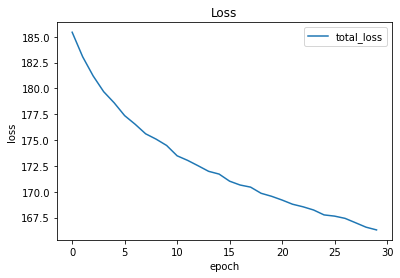

In [ ]:
pconv_unet = PConvUNet()

pconv_weights = torch.load('/content/project/checkpoints/PConvUNet_Rectangle_170.pth')
pconv_unet.load_state_dict(fix_model_state_dict(pconv_weights))

train_img_list, val_img_list = make_datapath_list(iorm='img', path='train_256_places365standard/data_256', phase='train', dataset_num=20000)
#mask_list = make_datapath_list(iorm='mask', path='')

mean = (0.5,)
std = (0.5,)
size = (image_size, 2 * image_size)
batch_size = batch_size
num_epochs = epoch

train_dataset = ImageDataset(img_list=train_img_list,
                                img_transform=ImageTransform(size=size, mean=mean, std=std),
                                mask_width=0.5)
val_dataset = ImageDataset(img_list=val_img_list,
                            img_transform=ImageTransform(size=size, mean=mean, std=std),
                            mask_width=0.5)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) 

pconv_unet_update = train_model(pconv_unet, dataloader=train_dataloader,
                                val_dataset=val_dataset, num_epochs=num_epochs,
                                parser=None, save_model_name='PConvUNet_Rectangle')

In [ ]:
%cp -av project/checkpoints/* drive/MyDrive/ECE_281B/checkpoints

In [ ]:
%cp -av project/result/* drive/MyDrive/ECE_281B/result

## adjusting loss term weights

### Epoch 200-250

In [ ]:
def train_model(pconv_unet, dataloader, val_dataset, num_epochs, parser, save_model_name='model'):

    check_dir()

    device = "cuda" if torch.cuda.is_available() else "cpu"

    pconv_unet.to(device)

    print("device:{}".format(device))
    '''
    if parser.finetune:
        lr = parser.lr_fine
        pconv_unet.fine_tune = True
    else:
        lr = parser.lr
    '''
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, pconv_unet.parameters()), lr=lr)
    criterion = Losses().to(device)
   
    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    lambda_dict = {'valid': 1.0, 'hole': 6.0, 'perceptual': 10, 'style': 10, 'tv': 0.1, 'bfm': 0.001}

    iteration = 1
    losses = []

    for epoch in range(250, num_epochs+250):

        pconv_unet.train()
        t_epoch_start = time.time()

        epoch_loss = 0.0

        print('-----------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs+250))
        print('(train)')

        for images, mask, gt in tqdm(dataloader):

            # if size of minibatch is 1, an error would be occurred.
            if images.size()[0] == 1:
                continue

            images = images.to(device)
            mask = mask.to(device)
            gt = gt.to(device)

            mini_batch_size = images.size()[0]

            output, _, fb = pconv_unet(images, mask, gt)
            loss_dict = criterion(images, mask, output, gt, fb)

            loss = torch.tensor(0.0).to(device)
            for key, _lambda in lambda_dict.items():
                loss += _lambda * loss_dict[key]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print('-----------')
        print('epoch {}'.format(epoch+1))
        print('total_loss:{:.4f}'.format(epoch_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))

        losses.append(epoch_loss/batch_size)
        t_epoch_start = time.time()
        plot_log(losses, save_model_name)

        if (epoch+1) % 10 == 0:
            torch.save(pconv_unet.state_dict(), 'project/checkpoints/'+save_model_name+'_'+str(epoch+1)+'.pth')
            pconv_unet.eval()
            evaluator = Evaluator(pconv_unet)
            metrics = evaluator.evaluate(val_dataset, device, 'project/{:s}/test_{:d}.jpg'.format('result', epoch+1))
            print('metrics: PSNR = {:.2f}, SSIM = {:.2f}'.format(metrics['PSNR'], metrics['SSIM']))
    return pconv_unet

In [ ]:
epoch =50
batch_size = 6
image_size = 256
lr = 1e-4

project/dataset/train_256_places365standard/data_256/a/aquarium/*.jpg
project/dataset/test/00000020.jpg
device:cuda
-----------
Epoch 201/250
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 201
total_loss:6194.6443
timer: 376.1899 sec.
metrics: PSNR = 16.08, SSIM = 3.76
-----------
Epoch 202/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 202
total_loss:6081.1092
timer: 375.8672 sec.
metrics: PSNR = 16.09, SSIM = 3.78
-----------
Epoch 203/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 203
total_loss:6036.0558
timer: 375.8065 sec.
metrics: PSNR = 16.11, SSIM = 3.82
-----------
Epoch 204/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 204
total_loss:6003.9284
timer: 375.8605 sec.
metrics: PSNR = 16.29, SSIM = 3.83
-----------
Epoch 205/250
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 205
total_loss:5979.3691
timer: 376.0585 sec.
metrics: PSNR = 16.20, SSIM = 3.82
-----------
Epoch 206/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 206
total_loss:5958.3322
timer: 375.1363 sec.
metrics: PSNR = 16.24, SSIM = 3.82
-----------
Epoch 207/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 207
total_loss:5938.3235
timer: 375.3025 sec.
metrics: PSNR = 16.29, SSIM = 3.84
-----------
Epoch 208/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 208
total_loss:5920.6359
timer: 375.6852 sec.
metrics: PSNR = 16.30, SSIM = 3.83
-----------
Epoch 209/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 209
total_loss:5903.8703
timer: 375.7708 sec.
metrics: PSNR = 16.27, SSIM = 3.85
-----------
Epoch 210/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 210
total_loss:5889.0421
timer: 375.3341 sec.
metrics: PSNR = 16.30, SSIM = 3.82
-----------
Epoch 211/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 211
total_loss:5874.1096
timer: 375.4815 sec.
metrics: PSNR = 16.38, SSIM = 3.85
-----------
Epoch 212/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 212
total_loss:5861.1793
timer: 375.3130 sec.
metrics: PSNR = 16.50, SSIM = 3.85
-----------
Epoch 213/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 213
total_loss:5849.4933
timer: 375.6781 sec.
metrics: PSNR = 16.46, SSIM = 3.88
-----------
Epoch 214/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 214
total_loss:5836.1522
timer: 375.5772 sec.
metrics: PSNR = 16.45, SSIM = 3.84
-----------
Epoch 215/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 215
total_loss:5825.8612
timer: 375.5098 sec.
metrics: PSNR = 16.48, SSIM = 3.87
-----------
Epoch 216/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 216
total_loss:5814.1644
timer: 375.7424 sec.
metrics: PSNR = 16.53, SSIM = 3.87
-----------
Epoch 217/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 217
total_loss:5803.4866
timer: 375.3178 sec.
metrics: PSNR = 16.36, SSIM = 3.89
-----------
Epoch 218/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 218
total_loss:5790.9524
timer: 375.5083 sec.
metrics: PSNR = 16.46, SSIM = 3.88
-----------
Epoch 219/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 219
total_loss:5781.8811
timer: 375.5411 sec.
metrics: PSNR = 16.60, SSIM = 3.91
-----------
Epoch 220/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 220
total_loss:5770.4378
timer: 375.6020 sec.
metrics: PSNR = 16.46, SSIM = 3.89
-----------
Epoch 221/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 221
total_loss:5760.9891
timer: 375.5241 sec.
metrics: PSNR = 16.52, SSIM = 3.88
-----------
Epoch 222/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 222
total_loss:5751.9719
timer: 375.1079 sec.
metrics: PSNR = 16.68, SSIM = 3.88
-----------
Epoch 223/250
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 223
total_loss:5742.1124
timer: 376.9073 sec.
metrics: PSNR = 16.61, SSIM = 3.89
-----------
Epoch 224/250
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 224
total_loss:5732.9213
timer: 376.1026 sec.
metrics: PSNR = 16.67, SSIM = 3.94
-----------
Epoch 225/250
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 225
total_loss:5723.7526
timer: 376.6140 sec.
metrics: PSNR = 16.54, SSIM = 3.90
-----------
Epoch 226/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 226
total_loss:5714.9779
timer: 375.7585 sec.
metrics: PSNR = 16.63, SSIM = 3.93
-----------
Epoch 227/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 227
total_loss:5705.7750
timer: 375.5884 sec.
metrics: PSNR = 16.69, SSIM = 3.96
-----------
Epoch 228/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 228
total_loss:5696.8079
timer: 375.5993 sec.
metrics: PSNR = 16.66, SSIM = 3.93
-----------
Epoch 229/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 229
total_loss:5688.6067
timer: 375.5281 sec.
metrics: PSNR = 16.53, SSIM = 3.91
-----------
Epoch 230/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 230
total_loss:5680.8767
timer: 375.3469 sec.
metrics: PSNR = 16.58, SSIM = 3.94
-----------
Epoch 231/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 231
total_loss:5671.7588
timer: 375.5662 sec.
metrics: PSNR = 16.73, SSIM = 3.94
-----------
Epoch 232/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 232
total_loss:5663.5715
timer: 375.5646 sec.
metrics: PSNR = 16.67, SSIM = 3.93
-----------
Epoch 233/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 233
total_loss:5656.2826
timer: 375.4134 sec.
metrics: PSNR = 16.74, SSIM = 3.95
-----------
Epoch 234/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 234
total_loss:5648.5184
timer: 375.4808 sec.
metrics: PSNR = 16.73, SSIM = 3.96
-----------
Epoch 235/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 235
total_loss:5641.8121
timer: 375.7509 sec.
metrics: PSNR = 16.62, SSIM = 3.94
-----------
Epoch 236/250
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 236
total_loss:5633.5625
timer: 376.0441 sec.
metrics: PSNR = 16.73, SSIM = 3.96
-----------
Epoch 237/250
(train)


100%|██████████| 2667/2667 [06:17<00:00,  7.07it/s]


-----------
epoch 237
total_loss:5626.9548
timer: 377.4392 sec.
metrics: PSNR = 16.83, SSIM = 3.97
-----------
Epoch 238/250
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 238
total_loss:5618.4115
timer: 376.0563 sec.
metrics: PSNR = 16.85, SSIM = 3.94
-----------
Epoch 239/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 239
total_loss:5611.3603
timer: 375.7804 sec.
metrics: PSNR = 16.74, SSIM = 3.96
-----------
Epoch 240/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 240
total_loss:5604.3794
timer: 375.5710 sec.
metrics: PSNR = 16.82, SSIM = 3.96
-----------
Epoch 241/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 241
total_loss:5597.0421
timer: 375.4339 sec.
metrics: PSNR = 16.78, SSIM = 3.97
-----------
Epoch 242/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 242
total_loss:5590.1150
timer: 375.8424 sec.
metrics: PSNR = 16.85, SSIM = 3.98
-----------
Epoch 243/250
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 243
total_loss:5582.8010
timer: 376.0447 sec.
metrics: PSNR = 16.82, SSIM = 3.96
-----------
Epoch 244/250
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 244
total_loss:5575.4742
timer: 376.3849 sec.
metrics: PSNR = 16.93, SSIM = 4.00
-----------
Epoch 245/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 245
total_loss:5569.4486
timer: 375.5571 sec.
metrics: PSNR = 16.69, SSIM = 3.95
-----------
Epoch 246/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 246
total_loss:5562.2290
timer: 375.6906 sec.
metrics: PSNR = 16.93, SSIM = 4.00
-----------
Epoch 247/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 247
total_loss:5555.8996
timer: 375.5749 sec.
metrics: PSNR = 16.95, SSIM = 3.98
-----------
Epoch 248/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 248
total_loss:5549.1825
timer: 375.2789 sec.
metrics: PSNR = 16.86, SSIM = 3.99
-----------
Epoch 249/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 249
total_loss:5543.4335
timer: 375.2767 sec.
metrics: PSNR = 16.94, SSIM = 4.02
-----------
Epoch 250/250
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 250
total_loss:5536.2636
timer: 375.5512 sec.
metrics: PSNR = 16.84, SSIM = 4.00


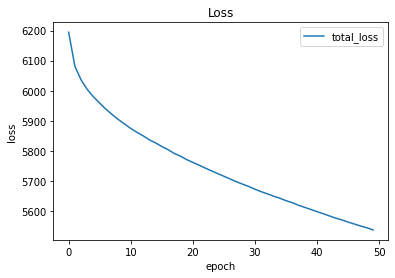

In [ ]:
pconv_unet = PConvUNet()

pconv_weights = torch.load('/content/project/checkpoints/PConvUNet_Rectangle_200.pth')
pconv_unet.load_state_dict(fix_model_state_dict(pconv_weights))

train_img_list, val_img_list = make_datapath_list(iorm='img', path='train_256_places365standard/data_256', phase='train', dataset_num=20000)
#mask_list = make_datapath_list(iorm='mask', path='')

mean = (0.5,)
std = (0.5,)
size = (image_size, 2 * image_size)
batch_size = batch_size
num_epochs = epoch

# generating a list of test image paths
test_img_list = []
test_rootpath = "project/dataset/test"
test_target_path = os.path.join(test_rootpath + '/*.jpg')

for path in glob.glob(test_target_path):
  test_img_list.append(path)
print(test_img_list[0])

train_dataset = ImageDataset(img_list=train_img_list,
                                img_transform=ImageTransform(size=size, mean=mean, std=std),
                                mask_width=0.5)
val_dataset = ImageDataset(img_list=test_img_list,
                            img_transform=ImageTransform(size=size, mean=mean, std=std),
                            mask_width=0.5)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) 

pconv_unet_update = train_model(pconv_unet, dataloader=train_dataloader,
                                val_dataset=val_dataset, num_epochs=num_epochs,
                                parser=None, save_model_name='PConvUNet_Rectangle')

### Epoch 250-300

project/dataset/train_256_places365standard/data_256/a/aquarium/*.jpg
project/dataset/test/00000008.jpg
device:cuda
-----------
Epoch 251/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 251
total_loss:5566.5324
timer: 376.1272 sec.
-----------
Epoch 252/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 252
total_loss:5547.3807
timer: 376.2020 sec.
-----------
Epoch 253/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 253
total_loss:5530.5919
timer: 376.5905 sec.
-----------
Epoch 254/300
(train)


100%|██████████| 2667/2667 [06:17<00:00,  7.07it/s]


-----------
epoch 254
total_loss:5515.4444
timer: 377.0303 sec.
-----------
Epoch 255/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 255
total_loss:5501.9673
timer: 376.8076 sec.
-----------
Epoch 256/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 256
total_loss:5488.5306
timer: 376.6920 sec.
-----------
Epoch 257/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 257
total_loss:5474.5512
timer: 376.8328 sec.
-----------
Epoch 258/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 258
total_loss:5461.5052
timer: 376.7935 sec.
-----------
Epoch 259/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 259
total_loss:5450.4516
timer: 376.5117 sec.
-----------
Epoch 260/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 260
total_loss:5438.3772
timer: 376.6692 sec.
metrics: PSNR = 16.91, SSIM = 0.50
-----------
Epoch 261/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 261
total_loss:5426.6098
timer: 376.1682 sec.
-----------
Epoch 262/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 262
total_loss:5415.2648
timer: 376.5575 sec.
-----------
Epoch 263/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 263
total_loss:5403.6057
timer: 376.8145 sec.
-----------
Epoch 264/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 264
total_loss:5393.8963
timer: 376.5646 sec.
-----------
Epoch 265/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 265
total_loss:5383.7098
timer: 376.7510 sec.
-----------
Epoch 266/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 266
total_loss:5372.2040
timer: 376.3124 sec.
-----------
Epoch 267/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 267
total_loss:5362.7777
timer: 376.6852 sec.
-----------
Epoch 268/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 268
total_loss:5352.7117
timer: 376.8672 sec.
-----------
Epoch 269/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 269
total_loss:5343.3484
timer: 376.7489 sec.
-----------
Epoch 270/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 270
total_loss:5332.4116
timer: 376.7197 sec.
metrics: PSNR = 17.03, SSIM = 0.51
-----------
Epoch 271/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 271
total_loss:5324.8478
timer: 376.1412 sec.
-----------
Epoch 272/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 272
total_loss:5313.9308
timer: 376.2205 sec.
-----------
Epoch 273/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 273
total_loss:5304.4148
timer: 376.4964 sec.
-----------
Epoch 274/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 274
total_loss:5296.6254
timer: 376.3151 sec.
-----------
Epoch 275/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 275
total_loss:5287.6374
timer: 376.2799 sec.
-----------
Epoch 276/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 276
total_loss:5279.2317
timer: 376.7040 sec.
-----------
Epoch 277/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 277
total_loss:5269.8453
timer: 376.9410 sec.
-----------
Epoch 278/300
(train)


100%|██████████| 2667/2667 [06:17<00:00,  7.07it/s]


-----------
epoch 278
total_loss:5262.0188
timer: 377.2815 sec.
-----------
Epoch 279/300
(train)


100%|██████████| 2667/2667 [06:17<00:00,  7.07it/s]


-----------
epoch 279
total_loss:5253.0536
timer: 377.1970 sec.
-----------
Epoch 280/300
(train)


100%|██████████| 2667/2667 [06:17<00:00,  7.07it/s]


-----------
epoch 280
total_loss:5244.5033
timer: 377.1265 sec.
metrics: PSNR = 17.17, SSIM = 0.51
-----------
Epoch 281/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 281
total_loss:5236.6988
timer: 376.8017 sec.
-----------
Epoch 282/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 282
total_loss:5229.6582
timer: 376.6764 sec.
-----------
Epoch 283/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 283
total_loss:5222.2291
timer: 376.7667 sec.
-----------
Epoch 284/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.07it/s]


-----------
epoch 284
total_loss:5213.3907
timer: 376.9896 sec.
-----------
Epoch 285/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 285
total_loss:5205.7852
timer: 376.9120 sec.
-----------
Epoch 286/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 286
total_loss:5198.8497
timer: 376.9669 sec.
-----------
Epoch 287/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 287
total_loss:5190.8573
timer: 376.8391 sec.
-----------
Epoch 288/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 288
total_loss:5183.5453
timer: 376.8656 sec.
-----------
Epoch 289/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 289
total_loss:5176.6560
timer: 376.8066 sec.
-----------
Epoch 290/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 290
total_loss:5169.5929
timer: 376.8441 sec.
metrics: PSNR = 17.29, SSIM = 0.52
-----------
Epoch 291/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 291
total_loss:5162.2202
timer: 376.5590 sec.
-----------
Epoch 292/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 292
total_loss:5154.7663
timer: 376.7244 sec.
-----------
Epoch 293/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 293
total_loss:5148.8005
timer: 376.6452 sec.
-----------
Epoch 294/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 294
total_loss:5140.9172
timer: 376.6091 sec.
-----------
Epoch 295/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 295
total_loss:5134.7502
timer: 376.5338 sec.
-----------
Epoch 296/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 296
total_loss:5128.2342
timer: 376.8361 sec.
-----------
Epoch 297/300
(train)


100%|██████████| 2667/2667 [06:17<00:00,  7.07it/s]


-----------
epoch 297
total_loss:5121.8157
timer: 377.0086 sec.
-----------
Epoch 298/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 298
total_loss:5114.8955
timer: 376.4940 sec.
-----------
Epoch 299/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 299
total_loss:5108.1747
timer: 376.8782 sec.
-----------
Epoch 300/300
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 300
total_loss:5102.3436
timer: 376.1927 sec.
metrics: PSNR = 17.39, SSIM = 0.52


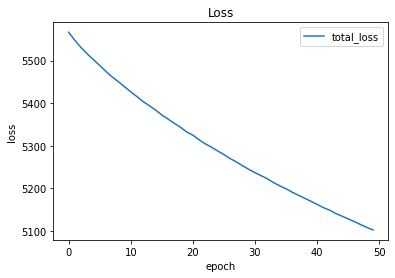

In [ ]:
pconv_unet = PConvUNet()

pconv_weights = torch.load('/content/project/checkpoints/PConvUNet_Rectangle_250.pth')
pconv_unet.load_state_dict(fix_model_state_dict(pconv_weights))

train_img_list, val_img_list = make_datapath_list(iorm='img', path='train_256_places365standard/data_256', phase='train', dataset_num=20000)
#mask_list = make_datapath_list(iorm='mask', path='')

mean = (0.5,)
std = (0.5,)
size = (image_size, 2 * image_size)
batch_size = batch_size
num_epochs = epoch

# generating a list of test image paths
test_img_list = []
test_rootpath = "project/dataset/test"
test_target_path = os.path.join(test_rootpath + '/*.jpg')

for path in glob.glob(test_target_path):
  test_img_list.append(path)
print(test_img_list[0])

train_dataset = ImageDataset(img_list=train_img_list,
                                img_transform=ImageTransform(size=size, mean=mean, std=std),
                                mask_width=0.5)
val_dataset = ImageDataset(img_list=test_img_list,
                            img_transform=ImageTransform(size=size, mean=mean, std=std),
                            mask_width=0.5)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) 

pconv_unet_update = train_model(pconv_unet, dataloader=train_dataloader,
                                val_dataset=val_dataset, num_epochs=num_epochs,
                                parser=None, save_model_name='PConvUNet_Rectangle')

## focus on perceptual loss

### Epoch 350-400

In [ ]:
def train_model(pconv_unet, dataloader, val_dataset, num_epochs, parser, lambda_dict, save_model_name='model'):

    check_dir()

    device = "cuda" if torch.cuda.is_available() else "cpu"

    pconv_unet.to(device)

    print("device:{}".format(device))
    '''
    if parser.finetune:
        lr = parser.lr_fine
        pconv_unet.fine_tune = True
    else:
        lr = parser.lr
    '''
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, pconv_unet.parameters()), lr=lr)
    criterion = Losses().to(device)
   
    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    #lambda_dict = {'valid': 1.0, 'hole': 6.0, 'perceptual': 50, 'style': 10, 'tv': 0.1, 'bfm': 0.001}

    iteration = 1
    losses = []

    for epoch in range(350, num_epochs+350):

        pconv_unet.train()
        t_epoch_start = time.time()

        epoch_loss = 0.0

        print('-----------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs+350))
        print('(train)')

        for images, mask, gt in tqdm(dataloader):

            # if size of minibatch is 1, an error would be occurred.
            if images.size()[0] == 1:
                continue

            images = images.to(device)
            mask = mask.to(device)
            gt = gt.to(device)

            mini_batch_size = images.size()[0]

            output, _, fb = pconv_unet(images, mask, gt)
            loss_dict = criterion(images, mask, output, gt, fb)

            loss = torch.tensor(0.0).to(device)
            for key, _lambda in lambda_dict.items():
                loss += _lambda * loss_dict[key]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print('-----------')
        print('epoch {}'.format(epoch+1))
        print('total_loss:{:.4f}'.format(epoch_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))

        losses.append(epoch_loss/batch_size)
        t_epoch_start = time.time()
        plot_log(losses, save_model_name)

        if (epoch+1) % 10 == 0:
            torch.save(pconv_unet.state_dict(), 'project/checkpoints/'+save_model_name+'_'+str(epoch+1)+'.pth')
            pconv_unet.eval()
            evaluator = Evaluator(pconv_unet)
            metrics = evaluator.evaluate(val_dataset, device, 'project/{:s}/test_{:d}.jpg'.format('result', epoch+1))
            print('metrics: PSNR = {:.2f}, SSIM = {:.2f}'.format(metrics['PSNR'], metrics['SSIM']))
    return pconv_unet

project/dataset/train_256_places365standard/data_256/a/aquarium/*.jpg
project/dataset/test/00000008.jpg
device:cuda
-----------
Epoch 301/350
(train)


100%|██████████| 2667/2667 [06:17<00:00,  7.07it/s]


-----------
epoch 301
total_loss:26015.5995
timer: 377.1100 sec.
-----------
Epoch 302/350
(train)


100%|██████████| 2667/2667 [06:17<00:00,  7.07it/s]


-----------
epoch 302
total_loss:25920.7984
timer: 377.0599 sec.
-----------
Epoch 303/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 303
total_loss:25853.1826
timer: 376.9136 sec.
-----------
Epoch 304/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 304
total_loss:25790.3015
timer: 376.5759 sec.
-----------
Epoch 305/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 305
total_loss:25736.7790
timer: 376.7009 sec.
-----------
Epoch 306/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 306
total_loss:25680.9396
timer: 376.8251 sec.
-----------
Epoch 307/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 307
total_loss:25630.6947
timer: 376.9529 sec.
-----------
Epoch 308/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 308
total_loss:25581.2042
timer: 375.4573 sec.
-----------
Epoch 309/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 309
total_loss:25539.3822
timer: 375.3760 sec.
-----------
Epoch 310/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 310
total_loss:25491.3152
timer: 375.2189 sec.
metrics: PSNR = 17.32, SSIM = 0.52
-----------
Epoch 311/350
(train)


100%|██████████| 2667/2667 [06:14<00:00,  7.12it/s]


-----------
epoch 311
total_loss:25455.2182
timer: 374.8420 sec.
-----------
Epoch 312/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 312
total_loss:25405.6385
timer: 375.5739 sec.
-----------
Epoch 313/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 313
total_loss:25365.1115
timer: 375.2599 sec.
-----------
Epoch 314/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 314
total_loss:25327.0775
timer: 375.3765 sec.
-----------
Epoch 315/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.09it/s]


-----------
epoch 315
total_loss:25286.2978
timer: 375.9535 sec.
-----------
Epoch 316/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 316
total_loss:25253.6359
timer: 375.5305 sec.
-----------
Epoch 317/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 317
total_loss:25213.3080
timer: 375.6998 sec.
-----------
Epoch 318/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 318
total_loss:25172.5604
timer: 376.3757 sec.
-----------
Epoch 319/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 319
total_loss:25140.5430
timer: 375.4839 sec.
-----------
Epoch 320/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 320
total_loss:25103.9530
timer: 375.5011 sec.
metrics: PSNR = 17.40, SSIM = 0.52
-----------
Epoch 321/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 321
total_loss:25065.8062
timer: 375.8546 sec.
-----------
Epoch 322/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 322
total_loss:25034.4808
timer: 375.3055 sec.
-----------
Epoch 323/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 323
total_loss:25000.2524
timer: 375.7577 sec.
-----------
Epoch 324/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 324
total_loss:24966.7632
timer: 376.5740 sec.
-----------
Epoch 325/350
(train)


100%|██████████| 2667/2667 [06:17<00:00,  7.07it/s]


-----------
epoch 325
total_loss:24935.6407
timer: 377.2263 sec.
-----------
Epoch 326/350
(train)


100%|██████████| 2667/2667 [06:17<00:00,  7.07it/s]


-----------
epoch 326
total_loss:24906.4902
timer: 377.4418 sec.
-----------
Epoch 327/350
(train)


100%|██████████| 2667/2667 [06:17<00:00,  7.07it/s]


-----------
epoch 327
total_loss:24870.1579
timer: 377.2603 sec.
-----------
Epoch 328/350
(train)


100%|██████████| 2667/2667 [06:17<00:00,  7.07it/s]


-----------
epoch 328
total_loss:24841.7887
timer: 377.2980 sec.
-----------
Epoch 329/350
(train)


100%|██████████| 2667/2667 [06:17<00:00,  7.07it/s]


-----------
epoch 329
total_loss:24808.5534
timer: 377.4273 sec.
-----------
Epoch 330/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 330
total_loss:24779.3963
timer: 375.6340 sec.
metrics: PSNR = 17.39, SSIM = 0.53
-----------
Epoch 331/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 331
total_loss:24752.4616
timer: 375.0148 sec.
-----------
Epoch 332/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 332
total_loss:24723.6978
timer: 375.1852 sec.
-----------
Epoch 333/350
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 333
total_loss:24692.0452
timer: 375.3975 sec.
-----------
Epoch 334/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 334
total_loss:24663.1402
timer: 376.0454 sec.
-----------
Epoch 335/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 335
total_loss:24634.4794
timer: 376.6053 sec.
-----------
Epoch 336/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 336
total_loss:24605.3427
timer: 376.7500 sec.
-----------
Epoch 337/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 337
total_loss:24576.1717
timer: 376.6841 sec.
-----------
Epoch 338/350
(train)


100%|██████████| 2667/2667 [06:17<00:00,  7.06it/s]


-----------
epoch 338
total_loss:24553.8442
timer: 377.6248 sec.
-----------
Epoch 339/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 339
total_loss:24524.6229
timer: 376.8466 sec.
-----------
Epoch 340/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 340
total_loss:24496.3207
timer: 376.9080 sec.
metrics: PSNR = 17.47, SSIM = 0.53
-----------
Epoch 341/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 341
total_loss:24465.1967
timer: 376.5765 sec.
-----------
Epoch 342/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 342
total_loss:24443.4206
timer: 376.6923 sec.
-----------
Epoch 343/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 343
total_loss:24414.5735
timer: 376.8093 sec.
-----------
Epoch 344/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 344
total_loss:24394.0022
timer: 376.9106 sec.
-----------
Epoch 345/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 345
total_loss:24366.6119
timer: 376.7433 sec.
-----------
Epoch 346/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 346
total_loss:24335.2532
timer: 376.6189 sec.
-----------
Epoch 347/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 347
total_loss:24315.4970
timer: 376.7836 sec.
-----------
Epoch 348/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 348
total_loss:24287.5112
timer: 376.8103 sec.
-----------
Epoch 349/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 349
total_loss:24266.4691
timer: 376.7384 sec.
-----------
Epoch 350/350
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 350
total_loss:24240.0184
timer: 376.7304 sec.
metrics: PSNR = 17.57, SSIM = 0.53


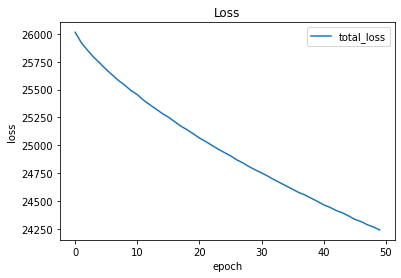

In [ ]:
pconv_unet = PConvUNet()

pconv_weights = torch.load('/content/project/checkpoints/PConvUNet_Rectangle_300.pth')
pconv_unet.load_state_dict(fix_model_state_dict(pconv_weights))

train_img_list, val_img_list = make_datapath_list(iorm='img', path='train_256_places365standard/data_256', phase='train', dataset_num=20000)
#mask_list = make_datapath_list(iorm='mask', path='')

mean = (0.5,)
std = (0.5,)
size = (image_size, 2 * image_size)
batch_size = batch_size
num_epochs = epoch

# generating a list of test image paths
test_img_list = []
test_rootpath = "project/dataset/test"
test_target_path = os.path.join(test_rootpath + '/*.jpg')

for path in glob.glob(test_target_path):
  test_img_list.append(path)
print(test_img_list[0])

train_dataset = ImageDataset(img_list=train_img_list,
                                img_transform=ImageTransform(size=size, mean=mean, std=std),
                                mask_width=0.5)
val_dataset = ImageDataset(img_list=test_img_list,
                            img_transform=ImageTransform(size=size, mean=mean, std=std),
                            mask_width=0.5)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) 

pconv_unet_update = train_model(pconv_unet, dataloader=train_dataloader,
                                val_dataset=val_dataset, num_epochs=num_epochs,
                                parser=None, save_model_name='PConvUNet_Rectangle')

### Epoch 350-400

project/dataset/train_256_places365standard/data_256/a/aquarium/*.jpg
project/dataset/test/00000020.jpg
device:cuda


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

-----------
Epoch 351/400
(train)


100%|██████████| 2667/2667 [06:29<00:00,  6.84it/s]


-----------
epoch 351
total_loss:49791.2236
timer: 389.8987 sec.
-----------
Epoch 352/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 352
total_loss:49625.5493
timer: 376.1433 sec.
-----------
Epoch 353/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 353
total_loss:49490.1847
timer: 375.4712 sec.
-----------
Epoch 354/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 354
total_loss:49371.9390
timer: 375.6209 sec.
-----------
Epoch 355/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 355
total_loss:49267.8030
timer: 376.1860 sec.
-----------
Epoch 356/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.09it/s]


-----------
epoch 356
total_loss:49184.0650
timer: 375.9920 sec.
-----------
Epoch 357/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.09it/s]


-----------
epoch 357
total_loss:49097.8903
timer: 376.0004 sec.
-----------
Epoch 358/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 358
total_loss:49002.0640
timer: 375.3943 sec.
-----------
Epoch 359/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 359
total_loss:48925.0906
timer: 375.1525 sec.
-----------
Epoch 360/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 360
total_loss:48853.9361
timer: 375.2547 sec.


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

metrics: PSNR = 17.24, SSIM = 0.52
-----------
Epoch 361/400
(train)


100%|██████████| 2667/2667 [06:14<00:00,  7.12it/s]


-----------
epoch 361
total_loss:48781.6393
timer: 374.6820 sec.
-----------
Epoch 362/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 362
total_loss:48706.9588
timer: 375.4842 sec.
-----------
Epoch 363/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 363
total_loss:48636.2742
timer: 375.7353 sec.
-----------
Epoch 364/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 364
total_loss:48569.2616
timer: 375.3651 sec.
-----------
Epoch 365/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 365
total_loss:48500.8356
timer: 375.4112 sec.
-----------
Epoch 366/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.11it/s]


-----------
epoch 366
total_loss:48431.5547
timer: 375.0241 sec.
-----------
Epoch 367/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 367
total_loss:48371.4334
timer: 375.4840 sec.
-----------
Epoch 368/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 368
total_loss:48308.7228
timer: 376.5988 sec.
-----------
Epoch 369/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 369
total_loss:48253.0515
timer: 376.6836 sec.
-----------
Epoch 370/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 370
total_loss:48188.4514
timer: 376.0753 sec.
metrics: PSNR = 17.45, SSIM = 0.53
-----------
Epoch 371/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 371
total_loss:48128.4158
timer: 376.5319 sec.
-----------
Epoch 372/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 372
total_loss:48075.5711
timer: 376.5883 sec.
-----------
Epoch 373/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 373
total_loss:48022.1860
timer: 376.6957 sec.
-----------
Epoch 374/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 374
total_loss:47957.8457
timer: 376.1286 sec.
-----------
Epoch 375/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 375
total_loss:47910.1955
timer: 376.4874 sec.
-----------
Epoch 376/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 376
total_loss:47852.2201
timer: 376.2608 sec.
-----------
Epoch 377/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 377
total_loss:47796.0700
timer: 376.0935 sec.
-----------
Epoch 378/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 378
total_loss:47742.8340
timer: 376.8102 sec.
-----------
Epoch 379/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 379
total_loss:47692.4058
timer: 376.5144 sec.
-----------
Epoch 380/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.07it/s]


-----------
epoch 380
total_loss:47650.3270
timer: 376.9701 sec.
metrics: PSNR = 17.26, SSIM = 0.53
-----------
Epoch 381/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 381
total_loss:47593.8352
timer: 376.3294 sec.
-----------
Epoch 382/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 382
total_loss:47537.0079
timer: 376.5962 sec.
-----------
Epoch 383/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 383
total_loss:47493.5245
timer: 376.6688 sec.
-----------
Epoch 384/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 384
total_loss:47432.8405
timer: 376.9471 sec.
-----------
Epoch 385/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 385
total_loss:47391.3154
timer: 375.6554 sec.
-----------
Epoch 386/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.10it/s]


-----------
epoch 386
total_loss:47353.2473
timer: 375.7975 sec.
-----------
Epoch 387/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.09it/s]


-----------
epoch 387
total_loss:47296.4166
timer: 375.9243 sec.
-----------
Epoch 388/400
(train)


100%|██████████| 2667/2667 [06:15<00:00,  7.09it/s]


-----------
epoch 388
total_loss:47251.5688
timer: 375.9611 sec.
-----------
Epoch 389/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 389
total_loss:47201.3891
timer: 376.4981 sec.
-----------
Epoch 390/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 390
total_loss:47149.7310
timer: 376.6770 sec.
metrics: PSNR = 17.72, SSIM = 0.54
-----------
Epoch 391/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 391
total_loss:47119.2274
timer: 376.3918 sec.
-----------
Epoch 392/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 392
total_loss:47067.6853
timer: 376.3740 sec.
-----------
Epoch 393/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 393
total_loss:47018.9888
timer: 376.6538 sec.
-----------
Epoch 394/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 394
total_loss:46976.4863
timer: 376.5516 sec.
-----------
Epoch 395/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 395
total_loss:46932.4968
timer: 376.5497 sec.
-----------
Epoch 396/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 396
total_loss:46894.3584
timer: 376.5170 sec.
-----------
Epoch 397/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.09it/s]


-----------
epoch 397
total_loss:46850.0005
timer: 376.2945 sec.
-----------
Epoch 398/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 398
total_loss:46802.3384
timer: 376.4790 sec.
-----------
Epoch 399/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 399
total_loss:46767.6316
timer: 376.6087 sec.
-----------
Epoch 400/400
(train)


100%|██████████| 2667/2667 [06:16<00:00,  7.08it/s]


-----------
epoch 400
total_loss:46712.1181
timer: 376.7352 sec.
metrics: PSNR = 17.04, SSIM = 0.53


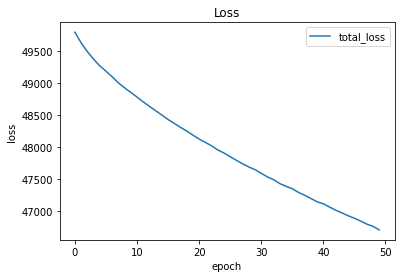

In [ ]:
lambda_dict = {'valid': 1.0, 'hole': 6.0, 'perceptual': 100, 'style': 10, 'tv': 0.1, 'bfm': 0.001}
pconv_unet = PConvUNet()

pconv_weights = torch.load('/content/project/checkpoints/PConvUNet_Rectangle_350.pth')
pconv_unet.load_state_dict(fix_model_state_dict(pconv_weights))

train_img_list, val_img_list = make_datapath_list(iorm='img', path='train_256_places365standard/data_256', phase='train', dataset_num=20000)
#mask_list = make_datapath_list(iorm='mask', path='')

mean = (0.5,)
std = (0.5,)
size = (image_size, 2 * image_size)
batch_size = batch_size
num_epochs = epoch

# generating a list of test image paths
test_img_list = []
test_rootpath = "project/dataset/test"
test_target_path = os.path.join(test_rootpath + '/*.jpg')

for path in glob.glob(test_target_path):
  test_img_list.append(path)
print(test_img_list[0])

train_dataset = ImageDataset(img_list=train_img_list,
                                img_transform=ImageTransform(size=size, mean=mean, std=std),
                                mask_width=0.5)
val_dataset = ImageDataset(img_list=test_img_list,
                            img_transform=ImageTransform(size=size, mean=mean, std=std),
                            mask_width=0.5)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) 

pconv_unet_update = train_model(pconv_unet, dataloader=train_dataloader,
                                val_dataset=val_dataset, num_epochs=num_epochs,
                                parser=None, lambda_dict=lambda_dict, save_model_name='PConvUNet_Rectangle')

### Epoch 430-500

In [ ]:
epoch = 70
batch_size = 16
image_size = 256
lr = 1e-4

project/dataset/train_256_places365standard/data_256/a/aquarium/*.jpg
project/dataset/test/00000020.jpg
device:cuda
-----------
Epoch 431/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.55it/s]


-----------
epoch 431
total_loss:6560.8325
timer: 282.0308 sec.
-----------
Epoch 432/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 432
total_loss:6535.6451
timer: 282.4121 sec.
-----------
Epoch 433/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 433
total_loss:6519.0176
timer: 282.1658 sec.
-----------
Epoch 434/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 434
total_loss:6506.1006
timer: 282.4119 sec.
-----------
Epoch 435/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 435
total_loss:6493.7678
timer: 282.4020 sec.
-----------
Epoch 436/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 436
total_loss:6484.4258
timer: 282.3081 sec.
-----------
Epoch 437/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 437
total_loss:6474.2357
timer: 282.8507 sec.
-----------
Epoch 438/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 438
total_loss:6465.2747
timer: 282.5352 sec.
-----------
Epoch 439/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 439
total_loss:6457.4346
timer: 282.6393 sec.
-----------
Epoch 440/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 440
total_loss:6449.2649
timer: 282.5330 sec.
metrics: PSNR = 17.79, SSIM = 0.56
-----------
Epoch 441/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 441
total_loss:6441.5562
timer: 282.5623 sec.
-----------
Epoch 442/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 442
total_loss:6434.5814
timer: 282.5734 sec.
-----------
Epoch 443/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 443
total_loss:6427.1149
timer: 282.4404 sec.
-----------
Epoch 444/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 444
total_loss:6420.3013
timer: 282.1431 sec.
-----------
Epoch 445/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 445
total_loss:6413.5105
timer: 282.4526 sec.
-----------
Epoch 446/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 446
total_loss:6406.9755
timer: 282.2876 sec.
-----------
Epoch 447/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 447
total_loss:6401.2379
timer: 282.1515 sec.
-----------
Epoch 448/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 448
total_loss:6395.6714
timer: 282.3771 sec.
-----------
Epoch 449/500
(train)


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


-----------
epoch 449
total_loss:6389.3126
timer: 282.4443 sec.
-----------
Epoch 450/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 450
total_loss:6383.2077
timer: 281.7214 sec.
metrics: PSNR = 17.84, SSIM = 0.56
-----------
Epoch 451/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 451
total_loss:6378.3544
timer: 281.2112 sec.
-----------
Epoch 452/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 452
total_loss:6372.5236
timer: 281.2064 sec.
-----------
Epoch 453/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 453
total_loss:6367.1599
timer: 281.0629 sec.
-----------
Epoch 454/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 454
total_loss:6362.0373
timer: 281.1987 sec.
-----------
Epoch 455/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 455
total_loss:6357.0696
timer: 281.2829 sec.
-----------
Epoch 456/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 456
total_loss:6351.8518
timer: 281.2987 sec.
-----------
Epoch 457/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 457
total_loss:6346.8195
timer: 281.2879 sec.
-----------
Epoch 458/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 458
total_loss:6342.6534
timer: 281.1580 sec.
-----------
Epoch 459/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 459
total_loss:6336.7682
timer: 281.2341 sec.
-----------
Epoch 460/500
(train)


100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


-----------
epoch 460
total_loss:6332.7448
timer: 280.9534 sec.
metrics: PSNR = 17.83, SSIM = 0.56
-----------
Epoch 461/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 461
total_loss:6327.4831
timer: 281.0534 sec.
-----------
Epoch 462/500
(train)


100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


-----------
epoch 462
total_loss:6322.7210
timer: 280.9703 sec.
-----------
Epoch 463/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 463
total_loss:6318.6996
timer: 281.0983 sec.
-----------
Epoch 464/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 464
total_loss:6314.1162
timer: 281.9680 sec.
-----------
Epoch 465/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 465
total_loss:6309.7418
timer: 281.4234 sec.
-----------
Epoch 466/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 466
total_loss:6305.3899
timer: 281.1973 sec.
-----------
Epoch 467/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 467
total_loss:6301.1542
timer: 281.3138 sec.
-----------
Epoch 468/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 468
total_loss:6296.8816
timer: 281.3208 sec.
-----------
Epoch 469/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 469
total_loss:6293.2137
timer: 281.6842 sec.
-----------
Epoch 470/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 470
total_loss:6288.8085
timer: 281.5268 sec.
metrics: PSNR = 17.80, SSIM = 0.56
-----------
Epoch 471/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 471
total_loss:6285.1983
timer: 281.4209 sec.
-----------
Epoch 472/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 472
total_loss:6281.3935
timer: 281.2746 sec.
-----------
Epoch 473/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 473
total_loss:6276.8919
timer: 281.3469 sec.
-----------
Epoch 474/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 474
total_loss:6272.8333
timer: 281.7105 sec.
-----------
Epoch 475/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 475
total_loss:6269.1905
timer: 281.7160 sec.
-----------
Epoch 476/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 476
total_loss:6264.7676
timer: 281.7797 sec.
-----------
Epoch 477/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 477
total_loss:6261.4865
timer: 281.5621 sec.
-----------
Epoch 478/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 478
total_loss:6258.0324
timer: 281.8230 sec.
-----------
Epoch 479/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 479
total_loss:6253.7073
timer: 281.6005 sec.
-----------
Epoch 480/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 480
total_loss:6250.5527
timer: 281.4563 sec.
metrics: PSNR = 17.81, SSIM = 0.56
-----------
Epoch 481/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 481
total_loss:6245.9643
timer: 281.5089 sec.
-----------
Epoch 482/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 482
total_loss:6242.4905
timer: 281.7827 sec.
-----------
Epoch 483/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 483
total_loss:6239.9385
timer: 281.4821 sec.
-----------
Epoch 484/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 484
total_loss:6236.0936
timer: 281.5596 sec.
-----------
Epoch 485/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


-----------
epoch 485
total_loss:6232.3637
timer: 281.3705 sec.
-----------
Epoch 486/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 486
total_loss:6228.7666
timer: 281.2905 sec.
-----------
Epoch 487/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 487
total_loss:6225.5917
timer: 281.1133 sec.
-----------
Epoch 488/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 488
total_loss:6223.1266
timer: 281.2851 sec.
-----------
Epoch 489/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 489
total_loss:6219.5006
timer: 281.1080 sec.
-----------
Epoch 490/500
(train)


100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


-----------
epoch 490
total_loss:6215.8129
timer: 280.8019 sec.
metrics: PSNR = 17.92, SSIM = 0.56
-----------
Epoch 491/500
(train)


100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


-----------
epoch 491
total_loss:6212.2327
timer: 280.9606 sec.
-----------
Epoch 492/500
(train)


100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


-----------
epoch 492
total_loss:6209.8140
timer: 280.8805 sec.
-----------
Epoch 493/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 493
total_loss:6205.9637
timer: 281.0263 sec.
-----------
Epoch 494/500
(train)


100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


-----------
epoch 494
total_loss:6202.0722
timer: 280.9564 sec.
-----------
Epoch 495/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 495
total_loss:6199.6854
timer: 281.0422 sec.
-----------
Epoch 496/500
(train)


100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


-----------
epoch 496
total_loss:6195.7306
timer: 281.0072 sec.
-----------
Epoch 497/500
(train)


100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


-----------
epoch 497
total_loss:6192.2095
timer: 280.7444 sec.
-----------
Epoch 498/500
(train)


100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


-----------
epoch 498
total_loss:6189.7848
timer: 281.1028 sec.
-----------
Epoch 499/500
(train)


100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


-----------
epoch 499
total_loss:6186.8619
timer: 280.8691 sec.
-----------
Epoch 500/500
(train)


100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


-----------
epoch 500
total_loss:6184.2419
timer: 280.8931 sec.
metrics: PSNR = 17.81, SSIM = 0.57


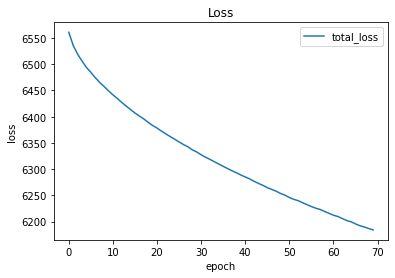

In [ ]:
lambda_dict = {'valid': 1.0, 'hole': 6.0, 'perceptual': 100, 'style': 10, 'tv': 0.1, 'bfm': 0.001}
pconv_unet = PConvUNet()

pconv_weights = torch.load('/content/project/checkpoints/PConvUNet_Rectangle_430.pth')
pconv_unet.load_state_dict(fix_model_state_dict(pconv_weights))

train_img_list, val_img_list = make_datapath_list(iorm='img', path='train_256_places365standard/data_256', phase='train', dataset_num=20000)
#mask_list = make_datapath_list(iorm='mask', path='')

mean = (0.5,)
std = (0.5,)
size = (image_size, 2 * image_size)
batch_size = batch_size
num_epochs = epoch

# generating a list of test image paths
test_img_list = []
test_rootpath = "project/dataset/test"
test_target_path = os.path.join(test_rootpath + '/*.jpg')

for path in glob.glob(test_target_path):
  test_img_list.append(path)
print(test_img_list[0])

train_dataset = ImageDataset(img_list=train_img_list,
                                img_transform=ImageTransform(size=size, mean=mean, std=std),
                                mask_width=0.5)
val_dataset = ImageDataset(img_list=test_img_list,
                            img_transform=ImageTransform(size=size, mean=mean, std=std),
                            mask_width=0.5)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) 

pconv_unet_update = train_model(pconv_unet, dataloader=train_dataloader,
                                val_dataset=val_dataset, num_epochs=num_epochs,
                                parser=None, lambda_dict=lambda_dict, save_model_name='PConvUNet_Rectangle')

## Training away from simply mirroring

### Epoch 500-600

project/dataset/train_256_places365standard/data_256/a/aquarium/*.jpg
project/dataset/test/00000012.jpg
device:cuda
-----------
Epoch 501/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 501
total_loss:438.8803
timer: 271.7142 sec.
-----------
Epoch 502/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 502
total_loss:430.2881
timer: 271.9063 sec.
-----------
Epoch 503/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 503
total_loss:427.0743
timer: 271.8554 sec.
-----------
Epoch 504/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 504
total_loss:424.9455
timer: 271.8098 sec.
-----------
Epoch 505/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 505
total_loss:423.2064
timer: 271.9350 sec.
-----------
Epoch 506/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 506
total_loss:421.6730
timer: 271.8476 sec.
-----------
Epoch 507/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 507
total_loss:420.5295
timer: 271.8023 sec.
-----------
Epoch 508/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 508
total_loss:419.4496
timer: 271.8198 sec.
-----------
Epoch 509/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 509
total_loss:418.2317
timer: 271.9702 sec.
-----------
Epoch 510/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 510
total_loss:417.3178
timer: 272.0635 sec.
metrics: PSNR = 14.65, SSIM = 0.43
-----------
Epoch 511/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 511
total_loss:416.3148
timer: 272.1283 sec.
-----------
Epoch 512/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 512
total_loss:415.5394
timer: 272.0990 sec.
-----------
Epoch 513/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 513
total_loss:414.6759
timer: 271.2728 sec.
-----------
Epoch 514/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 514
total_loss:413.8917
timer: 271.4731 sec.
-----------
Epoch 515/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 515
total_loss:413.0622
timer: 271.4301 sec.
-----------
Epoch 516/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 516
total_loss:412.3062
timer: 271.3870 sec.
-----------
Epoch 517/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 517
total_loss:411.5436
timer: 271.4634 sec.
-----------
Epoch 518/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 518
total_loss:410.8689
timer: 271.4349 sec.
-----------
Epoch 519/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 519
total_loss:410.2311
timer: 271.5363 sec.
-----------
Epoch 520/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 520
total_loss:409.6070
timer: 271.4804 sec.
metrics: PSNR = 14.68, SSIM = 0.42
-----------
Epoch 521/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 521
total_loss:408.9358
timer: 271.1148 sec.
-----------
Epoch 522/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 522
total_loss:408.2685
timer: 271.4165 sec.
-----------
Epoch 523/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 523
total_loss:407.7061
timer: 271.3083 sec.
-----------
Epoch 524/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 524
total_loss:407.0908
timer: 271.1822 sec.
-----------
Epoch 525/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 525
total_loss:406.6026
timer: 271.4094 sec.
-----------
Epoch 526/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 526
total_loss:405.8469
timer: 271.3398 sec.
-----------
Epoch 527/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 527
total_loss:405.3651
timer: 271.2048 sec.
-----------
Epoch 528/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 528
total_loss:404.8869
timer: 271.4049 sec.
-----------
Epoch 529/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 529
total_loss:404.2351
timer: 271.5547 sec.
-----------
Epoch 530/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 530
total_loss:403.7140
timer: 271.6037 sec.
metrics: PSNR = 14.98, SSIM = 0.43
-----------
Epoch 531/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 531
total_loss:403.1339
timer: 271.4906 sec.
-----------
Epoch 532/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 532
total_loss:402.6669
timer: 271.4042 sec.
-----------
Epoch 533/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 533
total_loss:402.2845
timer: 271.2375 sec.
-----------
Epoch 534/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 534
total_loss:401.6230
timer: 271.1252 sec.
-----------
Epoch 535/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 535
total_loss:401.1667
timer: 271.2855 sec.
-----------
Epoch 536/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 536
total_loss:400.6899
timer: 271.8150 sec.
-----------
Epoch 537/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 537
total_loss:400.1730
timer: 271.6635 sec.
-----------
Epoch 538/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 538
total_loss:399.7173
timer: 271.9532 sec.
-----------
Epoch 539/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 539
total_loss:399.3016
timer: 271.9006 sec.
-----------
Epoch 540/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 540
total_loss:398.9148
timer: 271.6847 sec.
metrics: PSNR = 14.89, SSIM = 0.43
-----------
Epoch 541/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 541
total_loss:398.3726
timer: 271.7059 sec.
-----------
Epoch 542/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 542
total_loss:397.8453
timer: 271.8620 sec.
-----------
Epoch 543/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 543
total_loss:397.4844
timer: 271.6253 sec.
-----------
Epoch 544/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 544
total_loss:397.0777
timer: 271.9111 sec.
-----------
Epoch 545/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 545
total_loss:396.5960
timer: 271.9258 sec.
-----------
Epoch 546/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 546
total_loss:396.1718
timer: 271.7085 sec.
-----------
Epoch 547/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 547
total_loss:395.8461
timer: 271.7000 sec.
-----------
Epoch 548/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 548
total_loss:395.3142
timer: 271.8854 sec.
-----------
Epoch 549/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 549
total_loss:394.9108
timer: 271.8480 sec.
-----------
Epoch 550/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 550
total_loss:394.5838
timer: 271.8139 sec.
metrics: PSNR = 14.69, SSIM = 0.42
-----------
Epoch 551/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 551
total_loss:394.0478
timer: 271.7774 sec.
-----------
Epoch 552/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.95it/s]


-----------
epoch 552
total_loss:393.7042
timer: 271.6152 sec.
-----------
Epoch 553/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 553
total_loss:393.3553
timer: 271.7736 sec.
-----------
Epoch 554/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 554
total_loss:392.9246
timer: 271.8507 sec.
-----------
Epoch 555/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 555
total_loss:392.4863
timer: 272.2670 sec.
-----------
Epoch 556/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 556
total_loss:392.1844
timer: 272.1289 sec.
-----------
Epoch 557/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 557
total_loss:391.7694
timer: 272.1021 sec.
-----------
Epoch 558/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 558
total_loss:391.4080
timer: 272.2950 sec.
-----------
Epoch 559/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 559
total_loss:390.9837
timer: 272.0347 sec.
-----------
Epoch 560/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 560
total_loss:390.5698
timer: 272.1345 sec.
metrics: PSNR = 14.77, SSIM = 0.42
-----------
Epoch 561/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 561
total_loss:390.3541
timer: 272.0557 sec.
-----------
Epoch 562/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 562
total_loss:389.9191
timer: 272.0996 sec.
-----------
Epoch 563/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 563
total_loss:389.5280
timer: 272.2394 sec.
-----------
Epoch 564/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 564
total_loss:389.2645
timer: 272.1939 sec.
-----------
Epoch 565/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 565
total_loss:388.8291
timer: 272.1340 sec.
-----------
Epoch 566/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 566
total_loss:388.5154
timer: 272.2139 sec.
-----------
Epoch 567/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 567
total_loss:388.2432
timer: 271.9391 sec.
-----------
Epoch 568/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 568
total_loss:387.8453
timer: 272.0887 sec.
-----------
Epoch 569/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 569
total_loss:387.4737
timer: 272.0175 sec.
-----------
Epoch 570/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 570
total_loss:387.1742
timer: 272.5486 sec.
metrics: PSNR = 14.86, SSIM = 0.43
-----------
Epoch 571/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 571
total_loss:386.8500
timer: 271.8485 sec.
-----------
Epoch 572/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 572
total_loss:386.4791
timer: 271.7700 sec.
-----------
Epoch 573/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 573
total_loss:386.1726
timer: 271.9032 sec.
-----------
Epoch 574/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 574
total_loss:386.0134
timer: 272.0305 sec.
-----------
Epoch 575/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 575
total_loss:385.5078
timer: 272.2017 sec.
-----------
Epoch 576/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 576
total_loss:385.2057
timer: 272.3018 sec.
-----------
Epoch 577/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 577
total_loss:384.8454
timer: 271.9386 sec.
-----------
Epoch 578/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 578
total_loss:384.6671
timer: 272.1174 sec.
-----------
Epoch 579/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 579
total_loss:384.2492
timer: 272.0195 sec.
-----------
Epoch 580/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 580
total_loss:383.9171
timer: 271.8632 sec.
metrics: PSNR = 14.77, SSIM = 0.42
-----------
Epoch 581/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 581
total_loss:383.6100
timer: 271.8071 sec.
-----------
Epoch 582/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 582
total_loss:383.3007
timer: 272.1096 sec.
-----------
Epoch 583/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 583
total_loss:382.9979
timer: 272.0610 sec.
-----------
Epoch 584/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 584
total_loss:382.7444
timer: 272.2693 sec.
-----------
Epoch 585/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 585
total_loss:382.3418
timer: 272.1714 sec.
-----------
Epoch 586/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 586
total_loss:382.1548
timer: 272.2158 sec.
-----------
Epoch 587/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.93it/s]


-----------
epoch 587
total_loss:381.8912
timer: 272.7594 sec.
-----------
Epoch 588/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 588
total_loss:381.5846
timer: 272.1166 sec.
-----------
Epoch 589/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 589
total_loss:381.1672
timer: 272.1044 sec.
-----------
Epoch 590/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 590
total_loss:380.8810
timer: 272.0505 sec.
metrics: PSNR = 14.92, SSIM = 0.43
-----------
Epoch 591/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 591
total_loss:380.7405
timer: 271.7879 sec.
-----------
Epoch 592/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 592
total_loss:380.3254
timer: 272.1805 sec.
-----------
Epoch 593/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 593
total_loss:380.0681
timer: 271.9322 sec.
-----------
Epoch 594/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 594
total_loss:379.7462
timer: 272.2905 sec.
-----------
Epoch 595/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 595
total_loss:379.5549
timer: 271.8999 sec.
-----------
Epoch 596/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 596
total_loss:379.2307
timer: 272.0088 sec.
-----------
Epoch 597/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 597
total_loss:378.8888
timer: 272.1277 sec.
-----------
Epoch 598/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 598
total_loss:378.6645
timer: 271.8918 sec.
-----------
Epoch 599/600
(train)


100%|██████████| 800/800 [04:31<00:00,  2.94it/s]


-----------
epoch 599
total_loss:378.4611
timer: 271.8185 sec.
-----------
Epoch 600/600
(train)


100%|██████████| 800/800 [04:32<00:00,  2.94it/s]


-----------
epoch 600
total_loss:378.2865
timer: 272.0723 sec.
metrics: PSNR = 14.81, SSIM = 0.43


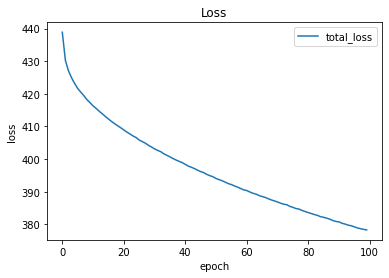

In [ ]:
lambda_dict = {'valid': 1.0, 'hole': 6.0, 'perceptual': 10, 'style': 10, 'tv': 0.1, 'bfm': 10}
pconv_unet = PConvUNet()

pconv_weights = torch.load('/content/project/checkpoints/PConvUNet_Rectangle_500.pth')
pconv_unet.load_state_dict(fix_model_state_dict(pconv_weights))

train_img_list, val_img_list = make_datapath_list(iorm='img', path='train_256_places365standard/data_256', phase='train', dataset_num=20000)
#mask_list = make_datapath_list(iorm='mask', path='')

mean = (0.5,)
std = (0.5,)
size = (image_size, 2 * image_size)
batch_size = batch_size
num_epochs = epoch

# generating a list of test image paths
test_img_list = []
test_rootpath = "project/dataset/test"
test_target_path = os.path.join(test_rootpath + '/*.jpg')

for path in glob.glob(test_target_path):
  test_img_list.append(path)
print(test_img_list[0])

train_dataset = ImageDataset(img_list=train_img_list,
                                img_transform=ImageTransform(size=size, mean=mean, std=std),
                                mask_width=0.5)
val_dataset = ImageDataset(img_list=test_img_list,
                            img_transform=ImageTransform(size=size, mean=mean, std=std),
                            mask_width=0.5)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) 

pconv_unet_update = train_model(pconv_unet, dataloader=train_dataloader,
                                val_dataset=val_dataset, num_epochs=num_epochs,
                                parser=None, lambda_dict=lambda_dict, save_model_name='PConvUNet_Rectangle')

In [ ]:
%cp -av project/result/* drive/MyDrive/ECE_281B/result

'project/result/test_0.jpg' -> 'drive/MyDrive/ECE_281B/result/test_0.jpg'
'project/result/test_1.jpg' -> 'drive/MyDrive/ECE_281B/result/test_1.jpg'
'project/result/test_2.jpg' -> 'drive/MyDrive/ECE_281B/result/test_2.jpg'
'project/result/test_510.jpg' -> 'drive/MyDrive/ECE_281B/result/test_510.jpg'
'project/result/test_520.jpg' -> 'drive/MyDrive/ECE_281B/result/test_520.jpg'
'project/result/test_530.jpg' -> 'drive/MyDrive/ECE_281B/result/test_530.jpg'
'project/result/test_540.jpg' -> 'drive/MyDrive/ECE_281B/result/test_540.jpg'
'project/result/test_550.jpg' -> 'drive/MyDrive/ECE_281B/result/test_550.jpg'
'project/result/test_560.jpg' -> 'drive/MyDrive/ECE_281B/result/test_560.jpg'
'project/result/test_570.jpg' -> 'drive/MyDrive/ECE_281B/result/test_570.jpg'
'project/result/test_580.jpg' -> 'drive/MyDrive/ECE_281B/result/test_580.jpg'
'project/result/test_590.jpg' -> 'drive/MyDrive/ECE_281B/result/test_590.jpg'
'project/result/test_600.jpg' -> 'drive/MyDrive/ECE_281B/result/test_600.jpg

In [ ]:
%cp -av project/checkpoints/* drive/MyDrive/ECE_281B/checkpoints

'project/checkpoints/PConvUNet_Rectangle_500.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_500.pth'
'project/checkpoints/PConvUNet_Rectangle_510.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_510.pth'
'project/checkpoints/PConvUNet_Rectangle_520.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_520.pth'
'project/checkpoints/PConvUNet_Rectangle_530.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_530.pth'
'project/checkpoints/PConvUNet_Rectangle_540.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_540.pth'
'project/checkpoints/PConvUNet_Rectangle_550.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_550.pth'
'project/checkpoints/PConvUNet_Rectangle_560.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_560.pth'
'project/checkpoints/PConvUNet_Rectangle_570.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_570.pth'
'project/checkpoints/PConvUNet_Rectangle_580.pth' -> 'dr

### Epoch 600-650

In [ ]:
epoch = 50
batch_size = 10
image_size = 256
lr = 1e-4

project/dataset/train_256_places365standard/data_256/a/aquarium/*.jpg
project/dataset/test/00000012.jpg
device:cuda
-----------
Epoch 601/650
(train)


100%|██████████| 1600/1600 [05:12<00:00,  5.12it/s]


-----------
epoch 601
total_loss:16193.8752
timer: 312.8063 sec.
-----------
Epoch 602/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.16it/s]


-----------
epoch 602
total_loss:16113.1118
timer: 309.8916 sec.
-----------
Epoch 603/650
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.16it/s]


-----------
epoch 603
total_loss:16059.3108
timer: 310.1235 sec.
-----------
Epoch 604/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.16it/s]


-----------
epoch 604
total_loss:16013.4444
timer: 310.0035 sec.
-----------
Epoch 605/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.16it/s]


-----------
epoch 605
total_loss:15974.4061
timer: 309.8510 sec.
-----------
Epoch 606/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 606
total_loss:15935.0827
timer: 309.4436 sec.
-----------
Epoch 607/650
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.16it/s]


-----------
epoch 607
total_loss:15904.4057
timer: 310.1492 sec.
-----------
Epoch 608/650
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.16it/s]


-----------
epoch 608
total_loss:15872.8039
timer: 310.2766 sec.
-----------
Epoch 609/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.16it/s]


-----------
epoch 609
total_loss:15845.4035
timer: 309.8477 sec.
-----------
Epoch 610/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 610
total_loss:15815.9063
timer: 309.4226 sec.
metrics: PSNR = 15.02, SSIM = 0.43
-----------
Epoch 611/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 611
total_loss:15791.3829
timer: 309.6506 sec.
-----------
Epoch 612/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 612
total_loss:15767.7791
timer: 309.3472 sec.
-----------
Epoch 613/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 613
total_loss:15745.4345
timer: 309.4652 sec.
-----------
Epoch 614/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 614
total_loss:15723.7705
timer: 309.6422 sec.
-----------
Epoch 615/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.16it/s]


-----------
epoch 615
total_loss:15701.3115
timer: 309.8604 sec.
-----------
Epoch 616/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.16it/s]


-----------
epoch 616
total_loss:15680.4699
timer: 309.9700 sec.
-----------
Epoch 617/650
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 617
total_loss:15660.6519
timer: 310.7296 sec.
-----------
Epoch 618/650
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 618
total_loss:15640.2427
timer: 310.5575 sec.
-----------
Epoch 619/650
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.15it/s]


-----------
epoch 619
total_loss:15623.0885
timer: 310.3925 sec.
-----------
Epoch 620/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.16it/s]


-----------
epoch 620
total_loss:15603.9788
timer: 309.9560 sec.
metrics: PSNR = 15.01, SSIM = 0.43
-----------
Epoch 621/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 621
total_loss:15588.7258
timer: 309.5593 sec.
-----------
Epoch 622/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 622
total_loss:15569.9199
timer: 309.3601 sec.
-----------
Epoch 623/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 623
total_loss:15555.5117
timer: 309.2450 sec.
-----------
Epoch 624/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 624
total_loss:15536.8671
timer: 309.1963 sec.
-----------
Epoch 625/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.18it/s]


-----------
epoch 625
total_loss:15521.4082
timer: 309.0750 sec.
-----------
Epoch 626/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 626
total_loss:15506.9001
timer: 309.2380 sec.
-----------
Epoch 627/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 627
total_loss:15489.9169
timer: 309.2633 sec.
-----------
Epoch 628/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.16it/s]


-----------
epoch 628
total_loss:15477.2515
timer: 309.8165 sec.
-----------
Epoch 629/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 629
total_loss:15460.6858
timer: 309.6231 sec.
-----------
Epoch 630/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 630
total_loss:15443.1023
timer: 309.6393 sec.
metrics: PSNR = 14.93, SSIM = 0.43
-----------
Epoch 631/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.18it/s]


-----------
epoch 631
total_loss:15432.2608
timer: 309.1048 sec.
-----------
Epoch 632/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.18it/s]


-----------
epoch 632
total_loss:15417.5503
timer: 309.0845 sec.
-----------
Epoch 633/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.18it/s]


-----------
epoch 633
total_loss:15404.5700
timer: 309.1230 sec.
-----------
Epoch 634/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 634
total_loss:15389.5894
timer: 309.6071 sec.
-----------
Epoch 635/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.18it/s]


-----------
epoch 635
total_loss:15376.3119
timer: 309.1659 sec.
-----------
Epoch 636/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.16it/s]


-----------
epoch 636
total_loss:15363.9610
timer: 309.8401 sec.
-----------
Epoch 637/650
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.16it/s]


-----------
epoch 637
total_loss:15350.1959
timer: 310.0171 sec.
-----------
Epoch 638/650
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.16it/s]


-----------
epoch 638
total_loss:15339.9664
timer: 310.0583 sec.
-----------
Epoch 639/650
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.16it/s]


-----------
epoch 639
total_loss:15325.0332
timer: 310.1389 sec.
-----------
Epoch 640/650
(train)


100%|██████████| 1600/1600 [05:10<00:00,  5.16it/s]


-----------
epoch 640
total_loss:15313.2831
timer: 310.0677 sec.
metrics: PSNR = 14.98, SSIM = 0.43
-----------
Epoch 641/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 641
total_loss:15300.9514
timer: 309.4380 sec.
-----------
Epoch 642/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.16it/s]


-----------
epoch 642
total_loss:15289.5392
timer: 309.8000 sec.
-----------
Epoch 643/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 643
total_loss:15275.4254
timer: 309.7089 sec.
-----------
Epoch 644/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 644
total_loss:15266.0990
timer: 309.6166 sec.
-----------
Epoch 645/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.16it/s]


-----------
epoch 645
total_loss:15252.2749
timer: 309.8602 sec.
-----------
Epoch 646/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 646
total_loss:15240.9048
timer: 309.7880 sec.
-----------
Epoch 647/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 647
total_loss:15230.4847
timer: 309.7552 sec.
-----------
Epoch 648/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.17it/s]


-----------
epoch 648
total_loss:15217.3905
timer: 309.6186 sec.
-----------
Epoch 649/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.16it/s]


-----------
epoch 649
total_loss:15206.6397
timer: 309.9154 sec.
-----------
Epoch 650/650
(train)


100%|██████████| 1600/1600 [05:09<00:00,  5.16it/s]


-----------
epoch 650
total_loss:15197.4306
timer: 309.8580 sec.
metrics: PSNR = 14.94, SSIM = 0.43


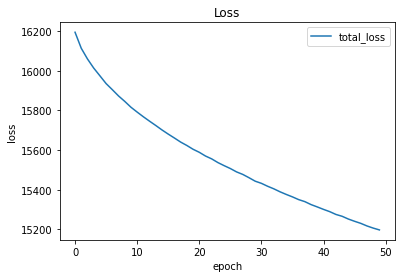

In [ ]:
lambda_dict = {'valid': 1.0, 'hole': 6.0, 'perceptual': 100, 'style': 10, 'tv': 0.1, 'bfm': 100}
pconv_unet = PConvUNet()

pconv_weights = torch.load('/content/project/checkpoints/PConvUNet_Rectangle_600.pth')
pconv_unet.load_state_dict(fix_model_state_dict(pconv_weights))

train_img_list, val_img_list = make_datapath_list(iorm='img', path='train_256_places365standard/data_256', phase='train', dataset_num=20000)
#mask_list = make_datapath_list(iorm='mask', path='')

mean = (0.5,)
std = (0.5,)
size = (image_size, 2 * image_size)
batch_size = batch_size
num_epochs = epoch

# generating a list of test image paths
test_img_list = []
test_rootpath = "project/dataset/test"
test_target_path = os.path.join(test_rootpath + '/*.jpg')

for path in glob.glob(test_target_path):
  test_img_list.append(path)

train_dataset = ImageDataset(img_list=train_img_list,
                                img_transform=ImageTransform(size=size, mean=mean, std=std),
                                mask_width=0.5)
val_dataset = ImageDataset(img_list=test_img_list,
                            img_transform=ImageTransform(size=size, mean=mean, std=std),
                            mask_width=0.5)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) 

pconv_unet_update = train_model(pconv_unet, dataloader=train_dataloader,
                                val_dataset=val_dataset, num_epochs=num_epochs,
                                parser=None, lambda_dict=lambda_dict, save_model_name='PConvUNet_Rectangle')

### Epoch 650-700

In [ ]:
def train_model(pconv_unet, dataloader, val_dataset, num_epochs, parser, lambda_dict, save_model_name='model'):

    check_dir()

    device = "cuda" if torch.cuda.is_available() else "cpu"

    pconv_unet.to(device)

    print("device:{}".format(device))
    '''
    if parser.finetune:
        lr = parser.lr_fine
        pconv_unet.fine_tune = True
    else:
        lr = parser.lr
    '''
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, pconv_unet.parameters()), lr=lr)
    criterion = Losses().to(device)
   
    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    #lambda_dict = {'valid': 1.0, 'hole': 6.0, 'perceptual': 50, 'style': 10, 'tv': 0.1, 'bfm': 0.001}

    iteration = 1
    losses = []

    for epoch in range(650, num_epochs+650):

        pconv_unet.train()
        t_epoch_start = time.time()

        epoch_loss = 0.0

        print('-----------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs+650))
        print('(train)')

        for images, mask, gt in tqdm(dataloader):

            # if size of minibatch is 1, an error would be occurred.
            if images.size()[0] == 1:
                continue

            images = images.to(device)
            mask = mask.to(device)
            gt = gt.to(device)

            mini_batch_size = images.size()[0]

            output, _, fb = pconv_unet(images, mask, gt)
            loss_dict = criterion(images, mask, output, gt, fb)

            loss = torch.tensor(0.0).to(device)
            for key, _lambda in lambda_dict.items():
                loss += _lambda * loss_dict[key]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print('-----------')
        print('epoch {}'.format(epoch+1))
        print('total_loss:{:.4f}'.format(epoch_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))

        losses.append(epoch_loss/batch_size)
        t_epoch_start = time.time()
        plot_log(losses, save_model_name)

        if (epoch+1) % 10 == 0:
            torch.save(pconv_unet.state_dict(), 'project/checkpoints/'+save_model_name+'_'+str(epoch+1)+'.pth')
            pconv_unet.eval()
            evaluator = Evaluator(pconv_unet)
            metrics = evaluator.evaluate(val_dataset, device, 'project/{:s}/test_{:d}.jpg'.format('result', epoch+1))
            print('metrics: PSNR = {:.2f}, SSIM = {:.2f}'.format(metrics['PSNR'], metrics['SSIM']))
    return pconv_unet

In [ ]:
epoch = 50
batch_size = 8
image_size = 256
lr = 1e-4

project/dataset/train_256_places365standard/data_256/a/aquarium/*.jpg
device:cuda


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

-----------
Epoch 651/700
(train)


100%|██████████| 2000/2000 [05:53<00:00,  5.65it/s]


-----------
epoch 651
total_loss:25060.6900
timer: 353.7454 sec.
-----------
Epoch 652/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 652
total_loss:24934.0064
timer: 341.8855 sec.
-----------
Epoch 653/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.85it/s]


-----------
epoch 653
total_loss:24847.8183
timer: 342.0579 sec.
-----------
Epoch 654/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.85it/s]


-----------
epoch 654
total_loss:24775.9983
timer: 342.0365 sec.
-----------
Epoch 655/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 655
total_loss:24710.4936
timer: 341.8621 sec.
-----------
Epoch 656/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 656
total_loss:24653.2445
timer: 342.2532 sec.
-----------
Epoch 657/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.85it/s]


-----------
epoch 657
total_loss:24602.5000
timer: 342.0271 sec.
-----------
Epoch 658/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.85it/s]


-----------
epoch 658
total_loss:24554.8010
timer: 342.1316 sec.
-----------
Epoch 659/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.85it/s]


-----------
epoch 659
total_loss:24511.1833
timer: 342.0345 sec.
-----------
Epoch 660/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 660
total_loss:24471.0152
timer: 341.9791 sec.


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

metrics: PSNR = 15.22, SSIM = 0.43
-----------
Epoch 661/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.85it/s]


-----------
epoch 661
total_loss:24431.8317
timer: 342.0520 sec.
-----------
Epoch 662/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 662
total_loss:24396.3594
timer: 342.1966 sec.
-----------
Epoch 663/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 663
total_loss:24359.2209
timer: 342.4818 sec.
-----------
Epoch 664/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.85it/s]


-----------
epoch 664
total_loss:24324.2851
timer: 342.1728 sec.
-----------
Epoch 665/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.85it/s]


-----------
epoch 665
total_loss:24290.4165
timer: 342.1269 sec.
-----------
Epoch 666/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 666
total_loss:24260.0165
timer: 342.2775 sec.
-----------
Epoch 667/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 667
total_loss:24225.7085
timer: 342.2262 sec.
-----------
Epoch 668/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.85it/s]


-----------
epoch 668
total_loss:24198.1098
timer: 342.1241 sec.
-----------
Epoch 669/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.85it/s]


-----------
epoch 669
total_loss:24171.7007
timer: 342.0674 sec.
-----------
Epoch 670/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 670
total_loss:24144.6341
timer: 342.0063 sec.
metrics: PSNR = 15.10, SSIM = 0.42
-----------
Epoch 671/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 671
total_loss:24114.7864
timer: 342.4692 sec.
-----------
Epoch 672/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 672
total_loss:24089.9345
timer: 341.6822 sec.
-----------
Epoch 673/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 673
total_loss:24062.7806
timer: 341.7150 sec.
-----------
Epoch 674/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 674
total_loss:24040.5766
timer: 341.8990 sec.
-----------
Epoch 675/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 675
total_loss:24011.8387
timer: 341.9295 sec.
-----------
Epoch 676/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 676
total_loss:23990.5821
timer: 341.6023 sec.
-----------
Epoch 677/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 677
total_loss:23965.6340
timer: 341.8593 sec.
-----------
Epoch 678/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 678
total_loss:23943.5462
timer: 341.8160 sec.
-----------
Epoch 679/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 679
total_loss:23918.5897
timer: 341.7508 sec.
-----------
Epoch 680/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 680
total_loss:23900.1316
timer: 341.7611 sec.
metrics: PSNR = 15.03, SSIM = 0.42
-----------
Epoch 681/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 681
total_loss:23875.6013
timer: 341.8006 sec.
-----------
Epoch 682/700
(train)


100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


-----------
epoch 682
total_loss:23853.0492
timer: 341.8376 sec.
-----------
Epoch 683/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.83it/s]


-----------
epoch 683
total_loss:23833.3868
timer: 342.8300 sec.
-----------
Epoch 684/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 684
total_loss:23807.4468
timer: 342.6251 sec.
-----------
Epoch 685/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 685
total_loss:23789.4439
timer: 342.6486 sec.
-----------
Epoch 686/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 686
total_loss:23770.8216
timer: 342.5404 sec.
-----------
Epoch 687/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.83it/s]


-----------
epoch 687
total_loss:23750.4436
timer: 342.8885 sec.
-----------
Epoch 688/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.83it/s]


-----------
epoch 688
total_loss:23728.2755
timer: 342.9244 sec.
-----------
Epoch 689/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 689
total_loss:23709.9223
timer: 342.7256 sec.
-----------
Epoch 690/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 690
total_loss:23690.1157
timer: 342.2776 sec.
metrics: PSNR = 14.99, SSIM = 0.42
-----------
Epoch 691/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.85it/s]


-----------
epoch 691
total_loss:23671.1757
timer: 342.1354 sec.
-----------
Epoch 692/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 692
total_loss:23654.2645
timer: 342.2260 sec.
-----------
Epoch 693/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 693
total_loss:23636.1354
timer: 342.2500 sec.
-----------
Epoch 694/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.85it/s]


-----------
epoch 694
total_loss:23615.7852
timer: 342.1656 sec.
-----------
Epoch 695/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 695
total_loss:23596.7800
timer: 342.2915 sec.
-----------
Epoch 696/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.83it/s]


-----------
epoch 696
total_loss:23577.8813
timer: 342.7934 sec.
-----------
Epoch 697/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 697
total_loss:23562.7070
timer: 342.4130 sec.
-----------
Epoch 698/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 698
total_loss:23541.8920
timer: 342.3590 sec.
-----------
Epoch 699/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 699
total_loss:23530.2969
timer: 342.3649 sec.
-----------
Epoch 700/700
(train)


100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


-----------
epoch 700
total_loss:23509.0660
timer: 342.4456 sec.
metrics: PSNR = 15.06, SSIM = 0.42


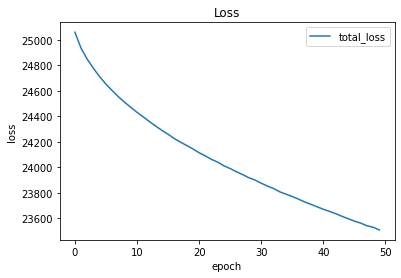

In [ ]:
lambda_dict = {'valid': 1.0, 'hole': 6.0, 'perceptual': 100, 'style': 10, 'tv': 0.1, 'bfm': 100}
pconv_unet = PConvUNet()

pconv_weights = torch.load('/content/project/checkpoints/PConvUNet_Rectangle_650.pth')
pconv_unet.load_state_dict(fix_model_state_dict(pconv_weights))

train_img_list, val_img_list = make_datapath_list(iorm='img', path='train_256_places365standard/data_256', phase='train', dataset_num=20000)
#mask_list = make_datapath_list(iorm='mask', path='')

mean = (0.5,)
std = (0.5,)
size = (image_size, 2 * image_size)
batch_size = batch_size
num_epochs = epoch

# generating a list of test image paths
test_img_list = []
test_rootpath = "project/dataset/test"
test_target_path = os.path.join(test_rootpath + '/*.jpg')

for path in glob.glob(test_target_path):
  test_img_list.append(path)

train_dataset = ImageDataset(img_list=train_img_list,
                                img_transform=ImageTransform(size=size, mean=mean, std=std),
                                mask_width=0.5)
val_dataset = ImageDataset(img_list=test_img_list,
                            img_transform=ImageTransform(size=size, mean=mean, std=std),
                            mask_width=0.5)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) 

pconv_unet_update = train_model(pconv_unet, dataloader=train_dataloader,
                                val_dataset=val_dataset, num_epochs=num_epochs,
                                parser=None, lambda_dict=lambda_dict, save_model_name='PConvUNet_Rectangle')

In [ ]:
%cp -av project/checkpoints/* drive/MyDrive/ECE_281B/checkpoints

'project/checkpoints/PConvUNet_Rectangle_500.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_500.pth'
'project/checkpoints/PConvUNet_Rectangle_550.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_550.pth'
'project/checkpoints/PConvUNet_Rectangle_580.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_580.pth'
'project/checkpoints/PConvUNet_Rectangle_590.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_590.pth'
'project/checkpoints/PConvUNet_Rectangle_600.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_600.pth'
'project/checkpoints/PConvUNet_Rectangle_610.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_610.pth'
'project/checkpoints/PConvUNet_Rectangle_620.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_620.pth'
'project/checkpoints/PConvUNet_Rectangle_650.pth' -> 'drive/MyDrive/ECE_281B/checkpoints/PConvUNet_Rectangle_650.pth'
'project/checkpoints/PConvUNet_Rectangle_660.pth' -> 'dr

# Evaluate

In [ ]:
def unnormalize(x):
    x = x.transpose(1, 3)
    # mean, std
    x = x * torch.Tensor((0.5, )) + torch.Tensor((0.5, ))
    x = x.transpose(1, 3)
    return x


In [ ]:
epoch = 50
batch_size = 10
image_size = 256
lr = 1e-4
mean = (0.5,)
std = (0.5,)
size = (image_size, 2 * image_size)
batch_size = batch_size
num_epochs = epoch


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pconv_unet = PConvUNet()
pconv_unet.to(device)
pconv_weights = torch.load('/content/project/checkpoints/PConvUNet_Rectangle_500.pth')
pconv_unet.load_state_dict(fix_model_state_dict(pconv_weights))
pconv_unet.eval()
evaluator = Evaluator(pconv_unet)

test_img_list = []
test_rootpath = "project/dataset/test"
test_target_path = os.path.join(test_rootpath + '/*.jpg')

for path in glob.glob(test_target_path):
  test_img_list.append(path)

val_dataset = ImageDataset(img_list=test_img_list,
                            img_transform=ImageTransform(size=size, mean=mean, std=std),
                            mask_width=0.5)

metrics = evaluator.evaluate(val_dataset, device, 'project/{:s}/final_test_500.jpg'.format('result'))
print('metrics: PSNR = {:.2f}, SSIM = {:.2f}'.format(metrics['PSNR'], metrics['SSIM']))


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

metrics: PSNR = 17.85, SSIM = 0.61


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pconv_unet = PConvUNet()
pconv_unet.to(device)
pconv_weights = torch.load('/content/project/checkpoints/PConvUNet_Rectangle_650.pth')
pconv_unet.load_state_dict(fix_model_state_dict(pconv_weights))
pconv_unet.eval()
evaluator = Evaluator(pconv_unet)

test_img_list = []
test_rootpath = "project/dataset/test"
test_target_path = os.path.join(test_rootpath + '/*.jpg')

for path in glob.glob(test_target_path):
  test_img_list.append(path)

val_dataset = ImageDataset(img_list=test_img_list,
                            img_transform=ImageTransform(size=size, mean=mean, std=std),
                            mask_width=0.5)

metrics = evaluator.evaluate(val_dataset, device, 'project/{:s}/final_test_650.jpg'.format('result'))
print('metrics: PSNR = {:.2f}, SSIM = {:.2f}'.format(metrics['PSNR'], metrics['SSIM']))

metrics: PSNR = 12.79, SSIM = 0.39


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pconv_unet = PConvUNet()
pconv_unet.to(device)
pconv_weights = torch.load('/content/project/checkpoints/PConvUNet_Rectangle_700.pth')
pconv_unet.load_state_dict(fix_model_state_dict(pconv_weights))
pconv_unet.eval()
evaluator = Evaluator(pconv_unet)

test_img_list = []
test_rootpath = "project/dataset/test"
test_target_path = os.path.join(test_rootpath + '/*.jpg')

for path in glob.glob(test_target_path):
  test_img_list.append(path)

val_dataset = ImageDataset(img_list=test_img_list,
                            img_transform=ImageTransform(size=size, mean=mean, std=std),
                            mask_width=0.5)

metrics = evaluator.evaluate(val_dataset, device, 'project/{:s}/final_test_700.jpg'.format('result'))
print('metrics: PSNR = {:.2f}, SSIM = {:.2f}'.format(metrics['PSNR'], metrics['SSIM']))

metrics: PSNR = 12.58, SSIM = 0.38


In [ ]:
%cp -av project/result/* drive/MyDrive/ECE_281B/result

'project/result/final_test_500.jpg' -> 'drive/MyDrive/ECE_281B/result/final_test_500.jpg'
'project/result/final_test_650.jpg' -> 'drive/MyDrive/ECE_281B/result/final_test_650.jpg'
'project/result/final_test_700.jpg' -> 'drive/MyDrive/ECE_281B/result/final_test_700.jpg'
'project/result/test_0.jpg' -> 'drive/MyDrive/ECE_281B/result/test_0.jpg'
'project/result/test_1.jpg' -> 'drive/MyDrive/ECE_281B/result/test_1.jpg'
'project/result/test_2.jpg' -> 'drive/MyDrive/ECE_281B/result/test_2.jpg'
